In [44]:
import vmlab
import igraph as ig
import pandas as pd
import matplotlib.pyplot as plt
from importlib import resources
import numpy as np
from scipy.sparse import csgraph

# Get variables for explaining fruit growth

To understand until which distance the fruits draw their carbon within the tree, some variables related to fruit growth are collected along the tree at several distances from the fruit. While connecting these variables to fruit masses, we hope to understand which of the distances have the most influence on the final fresh mass of the fruit.

### Data

One dmax value is chosen for the whole notebook ; it is the number of distances for which the functions are applied. It stands for the maximal distance until which fruits sink their carbon.

In [45]:
dmax = 22

Tree chosen to get the data for th ewhole notebook :

_Choose one tree and run the whole notebook at once_

In [46]:
# tree_name = 'E13'
# tree_name = 'E16'
tree_name = 'G3'

Sunlight fractions : computed from fisheye pictures of the GUs environments on the tree. The mean value on the fruting season is used here (to get only one value for each GU).

In [47]:
if tree_name == 'E13':
    sunlit_fractions_file_path = resources.path('vmlab.data.environment', 'fruting_season_sunlit_fractions_E13.csv')
elif tree_name == 'E16':
    sunlit_fractions_file_path = resources.path('vmlab.data.environment', 'fruting_season_sunlit_fractions_E16.csv')
elif tree_name == 'G3':
    sunlit_fractions_file_path = resources.path('vmlab.data.environment', 'fruting_season_sunlit_fractions_G3.csv')

sunlit_fraction_df = pd.read_csv(
            sunlit_fractions_file_path,
            sep='\\s+')
sunlit_fraction_df

G3_02D    G3_02E    G3_02G    G3_03A   G3_03C    G3_03D    G3_03E  \
0  0.216323  0.085417  0.078437  0.214229  0.14825  0.325344  0.040604   

     G3_03F    G3_04A    G3_04B  ...    G3_32E    G3_32G    G3_34A  G3_34B  \
0  0.120823  0.305896  0.184719  ...  0.028802  0.044792  0.103135   0.092   

     G3_34C    G3_34D    G3_34E    G3_35B        G3      mean  
0  0.109385  0.046542  0.180208  0.131604  0.084729  0.130779  

[1 rows x 144 columns]

Tree chosen for the whole notebook :

In [48]:
if tree_name == 'E13':
    tree_path = resources.path('vmlab.data.trees', 'tree_E13_completed.csv')
elif tree_name == 'E16':
    tree_path = resources.path('vmlab.data.trees', 'tree_E16_completed.csv')
elif tree_name == 'G3':
    tree_path = resources.path('vmlab.data.trees', 'tree_G3_completed.csv')

tree = pd.read_csv(tree_path)
graph = vmlab.to_graph(tree)

# for rows whose environment isn't specified : in exploration, multiplied by leaf number (=0 leaf anyways)
tree["environment_id"][pd.isna(tree["environment_id"])] = "mean"
tree

C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\3463598866.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["environment_id"][pd.isna(tree["environment_id"])] = "mean"


id         type  parent_id  topology__is_apical  \
0        0        trunk        NaN                  NaN   
1        1     scaffold        0.0                  0.0   
2        2     scaffold        1.0                  1.0   
3        3           GU        2.0                  0.0   
4        4  multiple_GU        2.0                  1.0   
...    ...          ...        ...                  ...   
1135  1135           GU     1133.0                  0.0   
1136  1136           GU     1115.0                  0.0   
1137  1137           GU     1136.0                  1.0   
1138  1138           GU     1137.0                  1.0   
1139  1139     scaffold      558.0                  0.0   

     arch_dev__pot_flowering_date  arch_dev__pot_nb_inflo  \
0                             NAT                     NaN   
1                             NAT                     NaN   
2                             NAT                     NaN   
3                             NAT                     NaN   
4                             NaT                     NaN   
...                           ...                     ...   
1135                          NAT                     NaN   
1136                          NAT                     NaN   
1137                          NAT                     NaN   
1138                          NAT                     NaN   
1139                          NAT                     NaN   

      arch_dev__pot_nb_fruit  growth__nb_leaf  growth__radius_gu  \
0                        NaN              0.0          14.300000   
1                        NaN              0.0           6.210000   
2                        NaN              0.0           5.900000   
3                        NaN              0.0           2.108500   
4                        NaN              0.0           4.600000   
...                      ...              ...                ...   
1135                     NaN              8.0           0.220000   
1136                     NaN              0.0           0.302974   
1137                     NaN              2.0           0.243556   
1138                     NaN              6.0           0.170500   
1139                     NaN              0.0           5.410000   

      appearance__final_length_gu environment_id  \
0                              20           mean   
1                              20           mean   
2                              20           mean   
3                              20           mean   
4                              20           mean   
...                           ...            ...   
1135                            6         G3_34E   
1136                            8           mean   
1137                           13         G3_34D   
1138                            4         G3_34D   
1139                           44           mean   

      light_interception__sunlit_fraction_col  
0                                           3  
1                                           3  
2                                           3  
3                                           3  
4                                           3  
...                                       ...  
1135                                        3  
1136                                        3  
1137                                        3  
1138                                        3  
1139                                        3  

[1140 rows x 12 columns]

In [49]:
#tree['environment_id'][tree['environment_id']=='E16_14A']= 'mean'

Fruit masses of the tree :

In [50]:
with resources.path('vmlab.data.fruit_quality', 'fruits_masses.csv') as path:
    fruit_mass = pd.read_csv(path,
                             sep=";",
                             usecols=['id_UC', 'arbre', 'id_branche','id_fruit', 'MS_ini', 'MF_rec'],
                            )
fruit_mass.index=fruit_mass['id_UC']
fruit_mass.drop(columns = ['id_UC'], inplace=True)
fruit_mass = fruit_mass[fruit_mass['arbre']== tree_name ]
fruit_mass = fruit_mass[fruit_mass.index.notna()]

fruit_mass = fruit_mass.sort_index()

fruit_mass = fruit_mass.groupby(["id_UC"]).mean("MF_rec")
fruit_mass

id_branche    MS_ini  MF_rec
id_UC                               
6.0            3.0       NaN  464.00
58.0           2.0  7.500932  443.15
69.0           3.0       NaN   83.00
71.0           3.0  5.870691  370.00
165.0          1.0  5.607603  413.56
...            ...       ...     ...
1072.0        35.0       NaN  359.00
1073.0        35.0       NaN  319.00
1079.0        35.0  5.790799  427.54
1080.0        35.0       NaN  373.00
1122.0        34.0  6.757691  444.01

[64 rows x 3 columns]

## Global exploration of the tree

In [51]:
print("Total leaves on the tree :", np.nansum(tree['growth__nb_leaf']))
print("Total fruits on the tree :", np.nansum(tree['arch_dev__pot_nb_fruit']))
print("Number of GUs on the tree: ", graph.ecount())

Total leaves on the tree : 8433.0
Total fruits on the tree : 95.0
Number of GUs on the tree:  1139


List of id of growth units bearing fruits on the studied tree :

In [52]:
fruity_GU = np.flatnonzero(tree['arch_dev__pot_nb_fruit'] > 0)
fruity_GU

array([  58,   69,   71,  165,  173,  205,  241,  246,  254,  261,  289,
        323,  330,  355,  358,  391,  400,  407,  409,  414,  415,  447,
        456,  460,  471,  476,  485,  488,  494,  501,  510,  525,  551,
        594,  622,  675,  679,  696,  709,  742,  743,  762,  769,  773,
        785,  814,  856,  891,  899,  912,  930,  971,  994,  995, 1007,
       1032, 1033, 1053, 1072, 1073, 1079, 1080, 1122], dtype=int64)

In [53]:
fruity_GU_types = tree.loc[np.flatnonzero(tree['arch_dev__pot_nb_fruit'] > 0), "type"]
fruity_GU_types

58          GU
69          GU
71          GU
165         GU
173     branch
         ...  
1072    branch
1073    branch
1079        GU
1080        GU
1122        GU
Name: type, Length: 63, dtype: object

In [54]:
tree.loc[fruity_GU, 'arch_dev__pot_nb_fruit']

58      2.0
69      2.0
71      1.0
165     1.0
173     4.0
       ... 
1072    1.0
1073    2.0
1079    1.0
1080    1.0
1122    1.0
Name: arch_dev__pot_nb_fruit, Length: 63, dtype: float64

### Undefined structures

Some structures on the tree are not as well described as regular growth units. They are labeled "branch", "branch_empty", "multiple_GU" or "undefined" (columns "type" in the dataframe). Theses undefined structures can lead to a bias in the variables picked up on the graph. They have to be detected to be then excluded from the dataset of variables explaining fruit growth.

In [55]:
def dist_to_undef (tree, dmax):
    graph = vmlab.to_graph(tree)
    adjacency = np.array(graph.get_adjacency())
    is_fruting = (tree['arch_dev__pot_nb_fruit'] > 0)

    distance_to_fruit = csgraph.shortest_path( 
                                adjacency,
                                indices=np.flatnonzero(is_fruting),
                                directed=False
                            ).astype(np.float32)
    distance_to_fruit[distance_to_fruit > dmax] = np.inf #collecting GU under a dmax distance only
    is_in_distance_to_fruit = np.isfinite(distance_to_fruit).astype(np.float32)
    dist_to_undef = np.copy(is_in_distance_to_fruit)
    dist_to_undef[dist_to_undef == 0] = np.nan
    dist_to_undef[dist_to_undef==1] = np.inf

    for i in range (len(np.flatnonzero(is_fruting))):
        for unit in tree.loc[is_in_distance_to_fruit[i]==1,'type'].index : 
            # if tree.loc[is_in_distance_to_fruit[i]==1,'type'][unit] == ("branch" or "branch_empty"or"scaffold_empty") : 
            if tree.loc[is_in_distance_to_fruit[i]==1,'type'][unit] !='GU' : 
                dist_to_undef[i,unit] = np.minimum(dist_to_undef[i,unit], distance_to_fruit[i,unit])

    return pd.DataFrame(np.nanmin(dist_to_undef, axis=1) , index = np.flatnonzero(is_fruting), columns = ["dist"])

In [56]:
table_dist_to_undef = dist_to_undef(tree,dmax)
table_dist_to_undef

dist
58    10.0
69    11.0
71    11.0
165   17.0
173    0.0
...    ...
1072   0.0
1073   0.0
1079   8.0
1080   8.0
1122  15.0

[63 rows x 1 columns]

## Collecting variables to explain fruit growth

Fruit growth is supposed to be explained by the quantity of carbon available for each fruit. This one is here approximated with the leaf number, the fruit number and the light environment, which determines the sunlight fraction available for the leaves. The "get_var_fruit_growth" function collects these variables along the tree branches, in order to connect them with fruit masses measured on the field.

The variables are computed as followed :
- **reachable leaves** at a distance dmax : sum of all the leaves borne by the concerned GU, mutliplied by a "sharing coefficient" if the GUs send carbon components to several fruits ;
- **sharing coefficient** with a distance dmax :  number of fruits from which a GU is at a dmax distance (to wit the number of fruit to which a GU is sending carbon) ;
- **light fraction** at a distance dmax : mean of the light fraction of each concerned GU, multiplied by the number of leaves borne by the GU. The "sharing coefficient" is also applied to the leaf number.

### Functions

In [57]:
def get_var_fruit_growth_GU(tree, dmax, year_sunlit_fractions, with_successors=False, see_carbon_flow: bool = False) : 
    '''
    Returns the available carbon for each fruit computed in 3 different ways. This function only considers fruits borne by GU of type 'GU'.
    
    Parameters
    ----------
    tree : :class:`pandas.DataFrame` object
        Required format is identical with what is specified for the 'tree' input in the vmlab.create_setup function.

    dmax : : :class:'int' object

    year_sunlit_fractions : :class:`pandas.DataFrame` object
        Required format is identical with what is specified for the 'sunlit_fraction_df' input in the vmlab.processes.light_interception initialization.

    with_successors : :class:'bool'
        If True, the reachable distance includes all the successors of each GU within the distance (in this cas, aggregate is not taken into account). If False, it 
        does not include the GUs if they are further that dmax.

    see_carbon_flow : :class:'bool' object
        True if the return of the function shows the carbon flow between all GUs and fruits.
        
    Returns
    -------
    available_carbon_raw, available_carbon_shared, available_carbon_shared_lit_env : :class:`numpay.array
    '''
    
    graph = vmlab.to_graph(tree)
    adjacency = np.array(graph.get_adjacency())
    GUs = tree.loc[tree.loc[:,'type'] == 'GU']

    # Initializaton (setting dtypes)
    distance_to_fruit = np.array([], dtype=np.float32)
    is_in_distance_to_fruit = np.array([], dtype=bool)
    is_fruting_and_GU_type = GUs['arch_dev__pot_nb_fruit'] > 0

    # Collecting GUs at the chosen distance dmax (with or without successors) from each fruit of the tree :
    if np.any(is_fruting_and_GU_type) : 
        distance_to_fruit = csgraph.shortest_path( 
                                    adjacency,
                                    indices=np.array(GUs[is_fruting_and_GU_type].index),
                                    directed=False
                                    ).astype(np.float32)

        # including successors :     
        if with_successors :
            distance_to_fruit[distance_to_fruit > dmax] = np.inf 
            is_in_distance_to_fruit = np.isfinite(distance_to_fruit).astype(np.float32)
            
            for fruit in is_in_distance_to_fruit :
                is_a_potential_mother = np.flatnonzero(fruit)
                distance_to_mother = csgraph.shortest_path( 
                                        adjacency,
                                        indices=is_a_potential_mother,
                                        directed=True
                                    ).astype(np.float32)    
                belongs_to_mother = np.isfinite(distance_to_mother).astype(np.float32)
                fruit += np.nansum(belongs_to_mother, axis=0)
                
            is_in_distance_to_fruit[is_in_distance_to_fruit!= 0] = 1

        # not including successors :
        else :
            distance_to_fruit[distance_to_fruit > dmax] = np.inf
            is_in_distance_to_fruit = np.isfinite(distance_to_fruit).astype(np.float32)

    # Collecting fruity and leafy GUs among the previously selected GUs :
    reachable_leaves = is_in_distance_to_fruit.copy()
    lit_frac = is_in_distance_to_fruit.copy()

    for i in range (len(np.flatnonzero(is_fruting_and_GU_type))):
        reachable_leaves [i,is_in_distance_to_fruit[i]==1] = tree.loc[is_in_distance_to_fruit[i]==1,'growth__nb_leaf']
        lit_frac [i,is_in_distance_to_fruit[i]==1] = year_sunlit_fractions.loc[:,tree.loc[is_in_distance_to_fruit[i]==1,'environment_id']] 

    # Taking into account the fact that some leaves share their carbon production between several fruits :
    leaf_fruit_sharing_number = np.nansum(np.transpose( 
            np.multiply(
                np.transpose(is_in_distance_to_fruit),                                                # GU bearing fruits to take into account
                np.array(GUs.loc[np.array(GUs[is_fruting_and_GU_type].index), 'arch_dev__pot_nb_fruit']) # number of fruits on these GUs                                                 
                )),
            axis=0)

    leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number 
    leaf_fruit_sharing_fraction[leaf_fruit_sharing_fraction==np.inf] = 0 

    # Computing variables of interest (np.nansum to avoid NA propagation) :
    sum_reachable_leaves = np.nansum(reachable_leaves, axis=1) 
    sum_reachable_leaves_shared = np.nansum(reachable_leaves*leaf_fruit_sharing_fraction, axis=1)
    available_carbon = np.nansum(lit_frac * reachable_leaves * leaf_fruit_sharing_fraction, axis=1)

    available_carbon_raw = sum_reachable_leaves 
    available_carbon_shared = sum_reachable_leaves_shared 
    available_carbon_shared_lit_env = available_carbon

    if see_carbon_flow :
        return reachable_leaves,reachable_leaves*leaf_fruit_sharing_fraction, lit_frac * reachable_leaves * leaf_fruit_sharing_fraction 
    
    else :
        return available_carbon_raw, available_carbon_shared, available_carbon_shared_lit_env

In [58]:
def get_var_fruit_growth(tree, dmax, year_sunlit_fractions, with_successors=False, see_carbon_flow:bool = False) : 
    '''
    Returns the available carbon for each fruit computed in 3 different ways. This function only considers fruits borne by GU of all types.
    
    Parameters
    ----------
    tree : :class:`pandas.DataFrame` object
        Required format is identical with what is specified for the 'tree' input in the vmlab.create_setup function.

    dmax : integer

    year_sunlit_fractions : :class:`pandas.DataFrame` object
        Required format is identical with what is specified for the 'sunlit_fraction_df' input in the vmlab.processes.light_interception initialization.

    with_successors : boolean
        If True, the reachable distance includes all the successors of each GU within the distance (in this cas, aggregate is not taken into account). If False, it 
        does not include the GUs if they are further that dmax.
        
    see_carbon_flow : :class:'bool' object
        True if the return of the function shows the carbon flow between all GUs and fruits.
       
    Returns
    -------
    available_carbon_raw, available_carbon_shared, available_carbon_shared_lit_env : :class:`numpay.array
    '''
  
    graph = vmlab.to_graph(tree)
    adjacency = np.array(graph.get_adjacency())

    # Initializaton (setting dtypes)
    distance_to_fruit = np.array([], dtype=np.float32)
    is_in_distance_to_fruit = np.array([], dtype=bool)
    is_fruting = tree['arch_dev__pot_nb_fruit'] > 0

    # Collecting GUs at the chosen distance (with or without successors) from each fruit of the tree :
    if np.any(is_fruting) : 
        distance_to_fruit = csgraph.shortest_path( 
                                    adjacency,
                                    indices=np.flatnonzero(is_fruting),
                                    directed=False
                                    ).astype(np.float32)

        # including successors :     
        if with_successors :
            distance_to_fruit[distance_to_fruit > dmax] = np.inf 
            is_in_distance_to_fruit = np.isfinite(distance_to_fruit).astype(np.float32)
            
            for fruit in is_in_distance_to_fruit :
                is_a_potential_mother = np.flatnonzero(fruit)
                distance_to_mother = csgraph.shortest_path( 
                                        adjacency,
                                        indices=is_a_potential_mother,
                                        directed=True
                                    ).astype(np.float32)    
                belongs_to_mother = np.isfinite(distance_to_mother).astype(np.float32)
                fruit += np.nansum(belongs_to_mother, axis=0)
                
            is_in_distance_to_fruit[is_in_distance_to_fruit!= 0] = 1

        # not including successors :
        else :
            distance_to_fruit[distance_to_fruit > dmax] = np.inf 
            is_in_distance_to_fruit = np.isfinite(distance_to_fruit).astype(np.float32)

    # Collecting fruity and leafy GUs among the previously selected GUs :
    reachable_leaves = is_in_distance_to_fruit.copy()
    lit_frac = is_in_distance_to_fruit.copy()

    for i in range (len(np.flatnonzero(is_fruting))):
        reachable_leaves [i,is_in_distance_to_fruit[i]==1] = tree.loc[is_in_distance_to_fruit[i]==1,'growth__nb_leaf']
        lit_frac [i,is_in_distance_to_fruit[i]==1] = year_sunlit_fractions.loc[:,tree.loc[is_in_distance_to_fruit[i]==1,'environment_id']] 

    # Taking into account the fact that some leaves share their carbon production between several fruits :
    leaf_fruit_sharing_number = np.nansum(np.transpose( 
    np.multiply(
        np.transpose(is_in_distance_to_fruit),                                    # GU bearing fruits to take into account
        np.array(tree.loc[np.flatnonzero(is_fruting), 'arch_dev__pot_nb_fruit']) # number of fruits on these GUs                                                 
        )),
    axis=0)

    leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number 
    leaf_fruit_sharing_fraction[leaf_fruit_sharing_fraction==np.inf] = 0 

    assert leaf_fruit_sharing_fraction.all() <= 1
    assert leaf_fruit_sharing_fraction.all() >= 0

    # Computing variables of interest (np.nansum to avoid NA propagation) :
    sum_reachable_leaves = np.nansum(reachable_leaves, axis=1) 

    sum_reachable_leaves_shared = np.nansum(reachable_leaves*leaf_fruit_sharing_fraction, axis=1)
    available_carbon = np.nansum(lit_frac * reachable_leaves * leaf_fruit_sharing_fraction, axis=1)

    available_carbon_raw = sum_reachable_leaves 
    available_carbon_shared = sum_reachable_leaves_shared 
    available_carbon_shared_lit_env = available_carbon 
    
    if see_carbon_flow :
        return reachable_leaves,reachable_leaves*leaf_fruit_sharing_fraction, lit_frac * reachable_leaves * leaf_fruit_sharing_fraction 
    
    else :
        return available_carbon_raw, available_carbon_shared, available_carbon_shared_lit_env

In [59]:
# ## a backup of the previous version of the above function 'get_var_fruit_growth' computed on every fruity structures (not only GU types)

# def get_var_fruit_growth_backup(tree, dmax, year_sunlit_fractions, with_successors=False, aggregate=True) : 
#     '''
#     Returns the number of fruits and leaves reachable by each GU bearing a fruit in the input tree and its mean light environment index, at a maximum distance dmax.
    
#     Parameters
#     ----------
#     tree : :class:`pandas.DataFrame` object
#         Required format is identical with what is specified for the 'tree' input in the vmlab.create_setup function.

#     dmax : integer

#     year_sunlit_fractions : :class:`pandas.DataFrame` object
#         Required format is identical with what is specified for the 'sunlit_fraction_df' input in the vmlab.processes.light_interception initialization.

#     method : character
#         If "with successors", the reachable distance includes all the successors of each GU within the distance (in this cas, aggregate is not taken into account). If "without successors", it 
#         does not include the if they are further that dmax.

#     aggregate : boolean
#         If True, the function collects values from every GU within the dmax distance. If False, only from GU at dmax distance.
    
#     Returns
#     -------
#     reachable_leaf, reachable_fruit, lit_sunlit : :class:`numpay.array
#     '''
#     graph = vmlab.to_graph(tree)
#     adjacency = np.array(graph.get_adjacency())
        
#     # Initializaton
#     distance_to_fruit = np.array([], dtype=np.float32)
#     is_in_distance_to_fruit = np.array([], dtype=bool)
#     is_fruting = (tree['arch_dev__pot_nb_fruit'] > 0)

#     sum_reachable_leaves = np.zeros([], dtype=bool)
#     sum_reachable_fruits = np.zeros([], dtype=bool)
#     available_carbon = np.zeros([], dtype=bool)

#     # Collecting GUs at the chosen distance from each fruit of the tree
#     if with_successors :
#         if np.any(is_fruting) : 
#             distance_to_fruit = csgraph.shortest_path( 
#                                         adjacency,
#                                         indices=np.flatnonzero(is_fruting),
#                                         directed=False
#                                     ).astype(np.float32)
            
#             distance_to_fruit[distance_to_fruit > dmax] = np.inf 
#             is_in_distance_to_fruit = np.isfinite(distance_to_fruit).astype(np.float32)
            
#             for fruit in is_in_distance_to_fruit :
#                 is_a_potential_mother = np.flatnonzero(fruit)
#                 distance_to_mother = csgraph.shortest_path( 
#                                         adjacency,
#                                         indices=is_a_potential_mother,
#                                         directed=True
#                                     ).astype(np.float32)    
#                 belongs_to_mother = np.isfinite(distance_to_mother).astype(np.float32)
#                 fruit += np.nansum(belongs_to_mother, axis=0)
            
#             is_in_distance_to_fruit[is_in_distance_to_fruit !=0] = 1

#     else :
#         if np.any(is_fruting) : 
#             distance_to_fruit = csgraph.shortest_path( 
#                                         adjacency,
#                                         indices=np.flatnonzero(is_fruting),
#                                         directed=False
#                                     ).astype(np.float32)
#             if aggregate :
#                 distance_to_fruit[distance_to_fruit > dmax] = np.inf #collecting GU at exactly a dmax distance
#             else : 
#                 distance_to_fruit[distance_to_fruit != dmax] = np.inf #collecting GU under a dmax distance
#             is_in_distance_to_fruit = np.isfinite(distance_to_fruit).astype(np.float32)
    
#     # Collecting fruity and leafy GUs among the previously selected GUs :
#     reachable_leaves = np.copy(is_in_distance_to_fruit) # avoids changing the original array
#     reachable_fruits = np.copy(is_in_distance_to_fruit)
#     lit_frac = np.copy(is_in_distance_to_fruit)

#     # for i in range (len(np.flatnonzero(is_fruting))):
#     #         for unit in tree.loc[is_in_distance_to_fruit[i]==1,'type'].index : # according to the structure type
#     #             if tree.loc[is_in_distance_to_fruit[i]==1,'type'][unit] =='GU' : 
#     #                 #dist_to_undef[i,unit] = np.minimum(dist_to_undef[i,unit], distance_to_fruit[i,unit])
#     #                 reachable_leaves [i,unit] = tree.loc[unit,'growth__nb_leaf']
#     #                 reachable_fruits [i,unit] = tree.loc[unit,'arch_dev__pot_nb_fruit'] #the fruit itself is taken into account
#     #                 lit_frac [i,unit] = year_sunlit_fractions.loc[:,tree.loc[unit,'environment_id']] 

#     for i in range (len(np.flatnonzero(is_fruting))):
#         reachable_leaves [i,is_in_distance_to_fruit[i]==1] = tree.loc[is_in_distance_to_fruit[i]==1,'growth__nb_leaf']
#         reachable_fruits [i,is_in_distance_to_fruit[i]==1] = tree.loc[is_in_distance_to_fruit[i]==1,'arch_dev__pot_nb_fruit'] #the fruit itself is taken into account
#         lit_frac [i,is_in_distance_to_fruit[i]==1] = year_sunlit_fractions.loc[:,tree.loc[is_in_distance_to_fruit[i]==1,'environment_id']] 

#     # Taking into account the fact that some leaves share their carbon production between several fruits :
#     leaf_fruit_sharing_fraction = np.full(fill_value=np.nansum(np.multiply(np.array(tree.loc[np.flatnonzero(tree['arch_dev__pot_nb_fruit'] > 0), 'arch_dev__pot_nb_fruit']), np.transpose(is_in_distance_to_fruit)),axis=1), shape=(len(np.flatnonzero(is_fruting)),len(np.nansum(is_in_distance_to_fruit, axis=0))))
#     leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_fraction
#     leaf_fruit_sharing_fraction[leaf_fruit_sharing_fraction==np.inf] = 0

#     assert leaf_fruit_sharing_fraction.all() <= 1
#     assert leaf_fruit_sharing_fraction.all() >= 0

#     # Computing variables of interest
#     available_carbon = np.nansum(lit_frac * reachable_leaves * leaf_fruit_sharing_fraction, axis=1)
#     sum_reachable_leaves = np.nansum(reachable_leaves * leaf_fruit_sharing_fraction, axis=1) #nansum to avoid NA propagation
#     sum_reachable_fruits = np.nansum(reachable_fruits, axis=1) #nansum to avoid NA propagation
#     LF = available_carbon / sum_reachable_fruits

#     return available_carbon, sum_reachable_leaves, sum_reachable_fruits, LF

### Error evaluation

Comparison between functions with or with fruits borne by segments of type different from 'GU'.

In [60]:
coef_with_branches = get_var_fruit_growth(tree, dmax, sunlit_fraction_df, with_successors=False)
coef_with_branches

(array([1286.,  993.,  993.,  203., 5836.,  999.,  960.,  960.,  960.,
        1500.,  768., 2879., 2318.,  706.,  706.,  745., 1430.,  950.,
         950.,  950.,  950., 2355.,  756.,  756.,  756.,  756.,  756.,
         791.,  666.,  537.,  584.,  725.,  584.,  846., 3236., 1090.,
        1090., 1537., 2495., 3307., 4360., 1645., 1114., 1073., 1000.,
        2804., 1844., 1456., 1026.,  937., 1026., 1616., 1003., 1511.,
        1003., 1616., 1616., 1616., 3391., 3391., 2036., 2036., 1542.],
       dtype=float32),
 array([ 80.20022918,  73.31386555,  73.31386555, 157.13291317,
        341.90353724,  59.44873638,  55.57373638,  55.57373638,
         55.57373638,  76.93999914,  42.08510001, 111.62938301,
         86.88723944,  33.41643791,  33.41643791,  44.26618538,
         55.11101923,  43.17659091,  43.17659091,  43.17659091,
         43.17659091, 108.97828337,  38.96991566,  38.96991566,
         38.96991566,  38.96991566,  38.96991566,  43.96991566,
         33.20515375,  28.90515

In [61]:
coef_without_branches = get_var_fruit_growth_GU(tree, dmax, sunlit_fraction_df, with_successors=False)
coef_without_branches

(array([1286.,  993.,  993.,  203.,  999.,  960.,  960.,  960., 1500.,
         768.,  706.,  706.,  745., 1430.,  950.,  950.,  950.,  950.,
         756.,  756.,  756.,  756.,  756.,  791.,  666.,  537.,  584.,
         725.,  584.,  846., 1090., 1090., 1537., 2495., 1645., 1114.,
        1073., 1000., 2804., 1844., 1456., 1026.,  937., 1026., 1616.,
        1003., 1511., 1003., 1616., 1616., 1616., 2036., 2036., 1542.],
       dtype=float32),
 array([150.77346235, 136.65364883, 136.65364883, 168.85014006,
        102.71079169,  94.87255639,  94.87255639,  94.87255639,
        144.98298616,  86.85364883, 123.91666667, 123.91666667,
        217.41666667, 152.09188412, 126.        , 126.        ,
        126.        , 126.        ,  54.94135154,  54.94135154,
         54.94135154,  54.94135154,  54.94135154,  61.94135154,
         47.44135154,  38.22706583,  64.7032563 ,  74.77468487,
         64.7032563 , 151.98648019, 147.35769231, 147.35769231,
        226.23648019, 274.92742701, 12

### Results

See notebook 'branch_exploration.ipynb' for reference curves on F14 branches. This aim of this section is to compare the results on the current tree to these reference models.

In [62]:
from scipy.optimize import curve_fit
import statsmodels.formula.api as smf

In [63]:
def model_weibull(x, asym, k, pwr):
    '''
    Returns the values of the Weibull to predict fresh fruit mass model not including dry mass.
    
    Parameters
    ----------
    x : :class:`numpy.array` object
        Available carbon.

    asym : :class:`float` object
        Fresh fruit mass asymptot in the model.

    k : :class:`float` object
        Parameter of the model.

    pwr : :class:`float` object
        Parameter of the model.

    Returns
    -------
    Values calculated : :class:`numpay.array
    '''
    return asym - asym*np.exp(-k*(x**pwr))

In [64]:
def model_linear(x, a, b):
    return a*x + b

In [65]:
def RRMSE (observed, predicted):
    ''' 
    Returns the  relative root mean square error between observed and predicted data.

    Parameters
    ----------
    observed : :class:`numpy.array` object

    predicted : :class:`numpy.array` object

    Returns
    -------
    RRMSE : :class:`float
    '''
    SCE = np.sum((predicted-observed)**2)
    RMSE = np.sqrt(SCE/len(observed))
    RRMSE = 100 * RMSE /np.mean(observed)
    return RRMSE

In [66]:
d=11

In [67]:
example = pd.DataFrame(get_var_fruit_growth_GU(tree, d, sunlit_fraction_df, with_successors=False)[2],
    columns=["available_carbon_lit_env"],
    index = np.flatnonzero((tree['arch_dev__pot_nb_fruit']>0) & (tree['type']=='GU')))
example['observed'] = fruit_mass["MF_rec"]
example['type'] = tree['type']
example.drop(labels = [i for i in example.index if np.any(example.loc[i, "type"]!="GU")], inplace=True)

C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\2850276878.py:82: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number


In [68]:
popt, pcov = curve_fit(f=model_weibull,
          xdata=example['available_carbon_lit_env'],
          ydata=example['observed'],
          p0=(490,0.12,1.1)
          
)
print(popt)
asym_opt, k_opt, pwr_opt = popt

[4.04735007e+02 3.64178572e-01 1.73134305e+00]


In [69]:
popt, pcov = curve_fit(f=model_linear,
          xdata=example['available_carbon_lit_env'],
          ydata=example['observed'],
          p0=(30,0)
          
)
print(popt)
a_opt, b_opt = popt

[-2.03480526e-01  4.00975946e+02]


Text(32.25117209305366, 30, 'RRMSE linear=24.31')

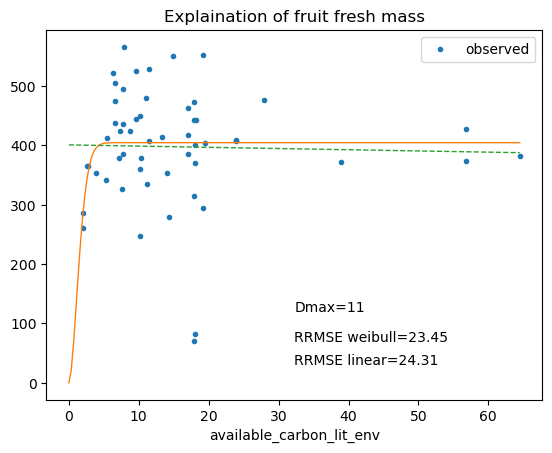

In [70]:
x = np.linspace(0, np.max(example['available_carbon_lit_env']), 200)
ax = example.plot(
    x="available_carbon_lit_env", y="observed",
    kind="line", title="Explaination of fruit fresh mass",
    linestyle="", marker=".",
    linewidth=1
)
ax.plot(x, model_weibull(x, asym_opt, k_opt, pwr_opt), linewidth=1)
ax.plot(x, model_linear(x, a_opt, b_opt), linewidth=1, linestyle="--")
plt.text(x=np.max(example['available_carbon_lit_env'])/2, y=120, s="".join(("Dmax=", str(d))))
plt.text(x=np.max(example['available_carbon_lit_env'])/2, y=70, s="".join(("RRMSE weibull=", str(np.round(RRMSE(observed=example['observed'], predicted=model_weibull(example['available_carbon_lit_env'], asym_opt, k_opt, pwr_opt)), decimals=2)))))
plt.text(x=np.max(example['available_carbon_lit_env'])/2, y=30, s="".join(("RRMSE linear=", str(np.round(RRMSE(observed=example['observed'], predicted=model_linear(example['available_carbon_lit_env'], a_opt, b_opt)), decimals=2)))))

In [71]:
example['predicted_linear'] = model_linear(example['available_carbon_lit_env'], a_opt, b_opt)
example['predicted_weibull'] = model_weibull(example['available_carbon_lit_env'], asym_opt, k_opt, pwr_opt)

Text(400, 100, 'Dmax : 11')

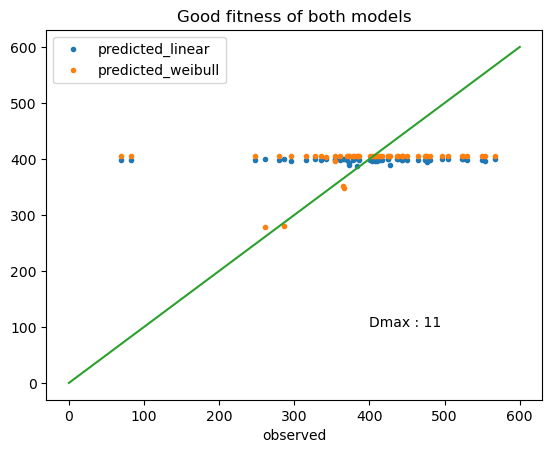

In [72]:
ax = example.plot(
    x="observed", y="predicted_linear",
    kind="line", title="Good fitness of both models",
    linestyle="", marker=".", linewidth=1
)
ax = example.plot(
    x="observed", y="predicted_weibull",
    kind="line",linestyle="", marker=".", ax=ax, linewidth=1
)

plt.plot([0,600],[0,600])
plt.text(x=400, y=100, s=" ".join(("Dmax :", str(d))) )

In [73]:
distance = np.linspace(0,30,31)
RRMSE_table = pd.DataFrame({'distance': distance,
                            'RRMSE_weibull' : [RRMSE(observed=example['observed'], predicted=model_weibull(get_var_fruit_growth_GU(tree, d, sunlit_fraction_df, with_successors=False)[2], asym_opt, k_opt, pwr_opt)) for d in distance],
                            'RRMSE_linear': [RRMSE(observed=example['observed'], predicted=model_linear(get_var_fruit_growth_GU(tree, d, sunlit_fraction_df, with_successors=False)[2], a_opt, b_opt)) for d in distance]
         })
RRMSE_table

C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\2850276878.py:82: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number
C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\2850276878.py:82: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number
C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\2850276878.py:82: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number
C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\2850276878.py:82: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number
C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\2850276878.py:82: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number
C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\2850276878.py:8

distance  RRMSE_weibull  RRMSE_linear
0        0.0      66.205999     24.337629
1        1.0      49.784068     24.348419
2        2.0      40.364045     24.340758
3        3.0      36.236456     24.346950
4        4.0      33.872239     24.350227
5        5.0      30.548407     24.357410
6        6.0      28.425157     24.374533
7        7.0      27.819884     24.233787
8        8.0      25.066537     24.149775
9        9.0      24.359215     24.233892
10      10.0      24.188743     24.310117
11      11.0      23.450478     24.309026
12      12.0      23.945641     24.348740
13      13.0      24.077034     24.370650
14      14.0      24.265399     24.386665
15      15.0      24.340887     24.380319
16      16.0      24.361069     24.370402
17      17.0      24.344468     24.366057
18      18.0      24.323006     24.366243
19      19.0      24.272557     24.298951
20      20.0      24.233797     24.296736
21      21.0      24.377205     24.312981
22      22.0      24.378458     24.275439
23      23.0      24.378570     24.264662
24      24.0      24.378479     24.288311
25      25.0      24.378112     24.275824
26      26.0      24.377899     24.259172
27      27.0      24.377689     24.252513
28      28.0      24.377142     24.263565
29      29.0      24.377100     24.272310
30      30.0      24.376631     24.272925

Text(0, 8, 'Excellent')

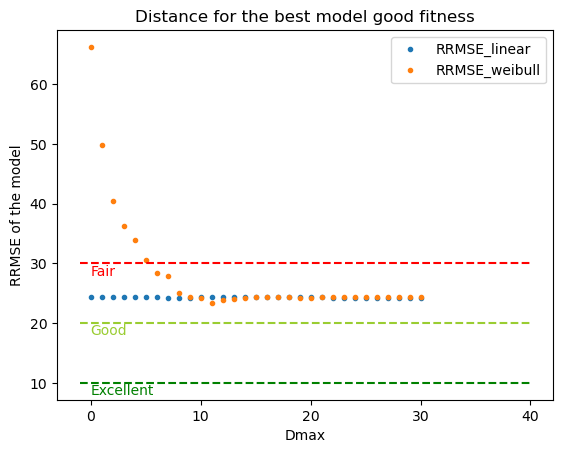

In [74]:
ax = RRMSE_table.plot(
    x="distance", y="RRMSE_linear",
    kind="line", title="Distance for the best model good fitness",
    linestyle="", marker=".", linewidth=1
)
ax = RRMSE_table.plot(
    x="distance", y="RRMSE_weibull",
    kind="line",linestyle="", marker=".", ax=ax, linewidth=1
)

plt.ylabel("RRMSE of the model")
plt.xlabel("Dmax")

plt.plot([-1,40],[30,30], linestyle="--", color='red')
plt.plot([-1,40],[20,20], linestyle="--", color="yellowgreen")
plt.plot([-1,40],[10,10], linestyle="--", color='green')
plt.text(x=0,y=28, s='Fair', color='red')
plt.text(x=0,y=18, s='Good', color="yellowgreen")
plt.text(x=0,y=8, s='Excellent', color='green')

Whathever the dmax distance chosen is, the adjustement plot shows that the prediction are good in mean (RRMSE of a fair model) but not for each predicted value. Let's compare our data to the reference curves built from F14 branches when we gather data for all distances dmax.

In [75]:
# result example fo the function above:
example1 = pd.DataFrame(np.transpose(get_var_fruit_growth_GU (tree, 10, sunlit_fraction_df, with_successors=False)), index=tree[(tree.loc[:,'type'] == 'GU') & (tree.loc[:,'arch_dev__pot_nb_fruit']>0) ].index, columns=["raw carbon", "shared carbon","shared light carbon"])
example1

C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\2850276878.py:82: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number


raw carbon  shared carbon  shared light carbon
58         558.0     115.500000            18.197246
69         545.0     109.000000            17.926413
71         545.0     109.000000            17.926413
165        156.0     156.000000            13.208600
205        148.0      72.833333             5.362354
241        154.0      36.350000             7.143249
246        154.0      36.350000             7.143249
254        154.0      36.350000             7.143249
261        493.0     453.933333            57.701821
289         86.0      86.000000             9.339031
355        295.0     147.500000            19.189177
358        295.0     147.500000            19.189177
391        284.0     284.000000            26.506584
400        611.0     131.916667            22.440494
407        591.0     111.916667            18.887647
409        430.0      71.666667            13.330899
414        591.0     111.916667            18.887647
415        591.0     111.916667            18.887647
456        455.0      64.358009            11.185513
460        411.0      55.558009            10.129811
471        411.0      55.558009            10.129811
476        411.0      55.558009            10.129811
485        199.0      27.900000             4.910198
488        368.0     112.224675            14.278967
494        106.0      14.631818             2.452972
501         87.0      12.731818             2.005932
510         66.0      35.000000             1.731938
525        236.0     108.333333            12.322752
551         76.0      66.333333             5.757903
594        104.0      52.000000             7.928979
675        506.0     168.666667            27.050608
679        506.0     168.666667            27.050608
696         82.0      33.333333             7.250049
709        178.0      76.833333            12.314527
762         93.0      47.433333             5.469089
769         81.0      28.433333             3.467136
773         58.0      20.766667             2.621126
785         48.0      42.100000             7.716581
814         96.0      63.266667             5.596381
856        174.0      87.000000            13.293969
891         40.0      20.000000             1.639167
899        375.0     122.083333            20.718265
912        320.0      95.750000            16.007323
930        390.0     113.083333            18.686228
971        201.0     119.733333            10.876934
994        244.0      56.033333            12.598882
995        279.0      82.033333            14.612007
1007       244.0      56.033333            12.598882
1032       154.0      36.283333             3.881092
1033       154.0      36.283333             3.881092
1053       154.0      36.283333             3.881092
1079       860.0     430.000000            56.805096
1080       860.0     430.000000            56.805096
1122        52.0      52.000000             6.893083

In [76]:
example2 = pd.DataFrame(np.transpose(get_var_fruit_growth(tree, 5, sunlit_fraction_df, with_successors=False)), index=np.flatnonzero(tree["arch_dev__pot_nb_fruit"]>0), columns=["raw carbon", "shared carbon","shared light carbon"])
example2

C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\3970760918.py:81: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number


raw carbon  shared carbon  shared light carbon
58         137.0      68.500000             8.393896
69         134.0      44.666667             7.238875
71         134.0      44.666667             7.238875
165         21.0      21.000000             2.616766
173        415.0     103.750000            13.568314
...          ...            ...                  ...
1072       773.0     257.266667            33.645552
1073       773.0     257.266667            33.645552
1079        79.0      38.600000             5.617483
1080        79.0      38.600000             5.617483
1122        21.0      21.000000             3.449250

[63 rows x 3 columns]

<Axes: >

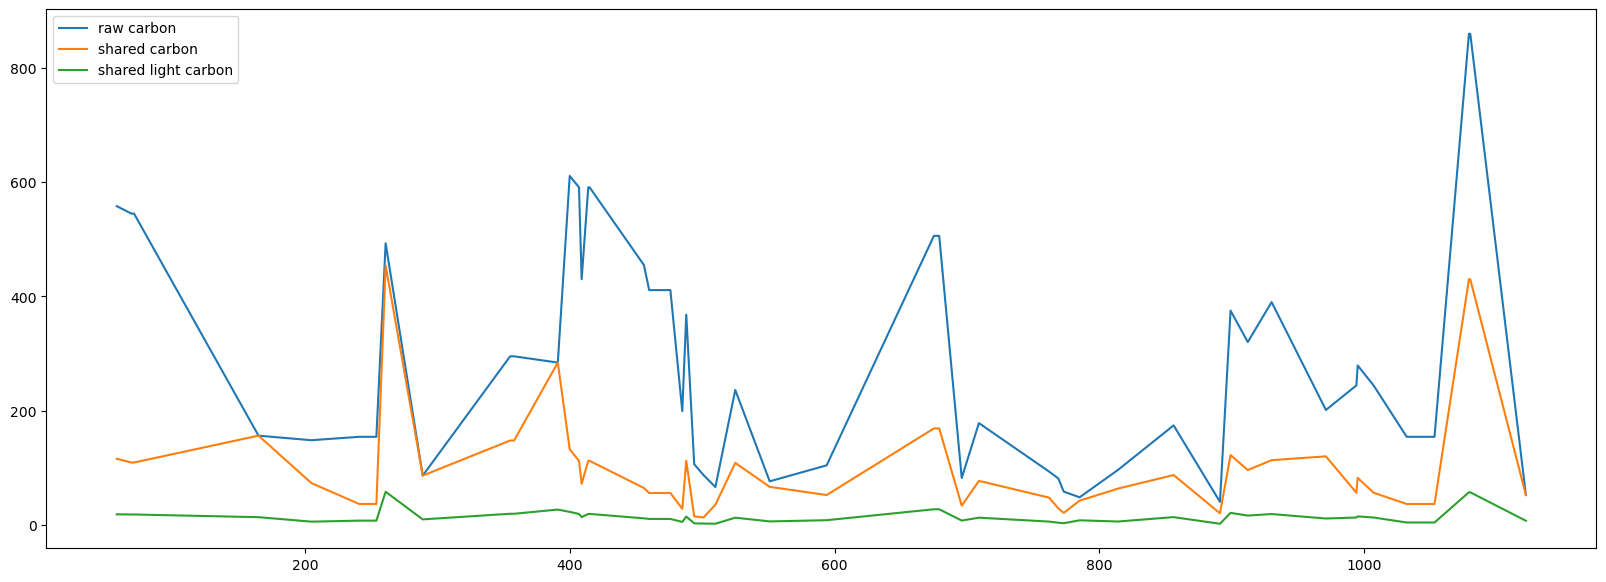

In [77]:
example1.plot(figsize=(20,7))

<Axes: >

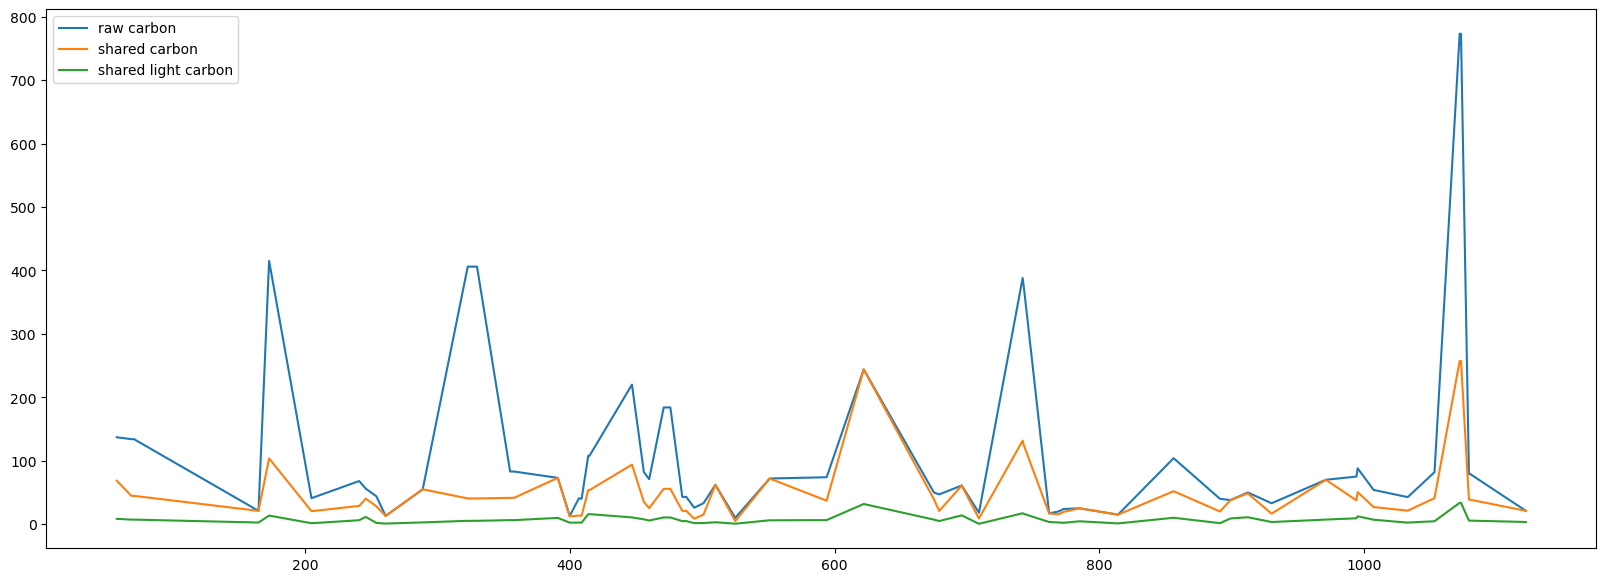

In [78]:
example2.plot(figsize=(20,7))

To get the results of exploration, you need : 
- table_undef to be defined
- fruit_mass to be defined (and thus tree_name)

the function get_var_fruit_growth_GU

In [79]:
# collecting variables at the distance dmax :
results = [get_var_fruit_growth_GU(tree, i, sunlit_fraction_df, with_successors=False) for i in range (0, dmax+1)]

# results are fitted into a dataframe :
col_names = pd.MultiIndex.from_product(([i for i in range(0, dmax+1)],["raw carbon", "shared carbon","shared light carbon"]), names=["distance","variable"])
final_table = pd.DataFrame(np.transpose(np.vstack(results)), index=tree[(tree.loc[:,'type'] == 'GU') & (tree.loc[:,'arch_dev__pot_nb_fruit']>0) ].index, columns=col_names, dtype=float)
final_table = final_table.swaplevel("distance","variable",1).sort_index(axis=1,level="variable")

final_table["GU_type"] = tree.loc[tree['arch_dev__pot_nb_fruit'] >0]['type']
final_table["dist_to_undef"] = table_dist_to_undef

final_table['tree'] = np.full(fill_value = tree_name, shape = len(final_table.index))
final_table['fresh_mass'] = fruit_mass['MF_rec']
final_table['dry_mass'] = fruit_mass['MS_ini']
final_table = np.transpose(final_table)
final_table

C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\2850276878.py:82: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number
C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\2850276878.py:82: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number
C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\2850276878.py:82: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number
C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\2850276878.py:82: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number
C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\2850276878.py:82: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number
C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\2850276878.py:8

58     69        71        165    205        241   \
variable      distance                                                          
raw carbon    0             18.0    7.0      10.0       7.0   14.0       18.0   
              1             18.0   16.0      19.0       8.0   26.0       35.0   
              2             18.0   76.0      76.0      18.0   26.0       47.0   
              3             32.0   83.0      83.0      18.0   28.0       51.0   
              4            100.0  132.0     132.0      19.0   29.0       55.0   
...                          ...    ...       ...       ...    ...        ...   
GU_type                       GU     GU        GU        GU     GU         GU   
dist_to_undef               10.0   11.0      11.0      17.0   12.0       13.0   
tree                          G3     G3        G3        G3     G3         G3   
fresh_mass                443.15   83.0     370.0    413.56  342.0     437.64   
dry_mass                7.500932    NaN  5.870691  5.607603    NaN  11.380306   

                            246    254       261       289   ...   971   \
variable      distance                                       ...          
raw carbon    0             18.0    6.0       8.0      15.0  ...   11.0   
              1             33.0   20.0      13.0      31.0  ...   12.0   
              2             35.0   23.0      13.0      41.0  ...   47.0   
              3             38.0   28.0      13.0      51.0  ...   61.0   
              4             42.0   32.0      13.0      53.0  ...   61.0   
...                          ...    ...       ...       ...  ...    ...   
GU_type                       GU     GU        GU        GU  ...     GU   
dist_to_undef               13.0   13.0       9.0      13.0  ...   11.0   
tree                          G3     G3        G3        G3  ...     G3   
fresh_mass                504.97  475.0    382.82    525.07  ...  464.0   
dry_mass                8.339092    NaN  5.057293  7.564448  ...    NaN   

                            994    995      1007      1032   1033      1053  \
variable      distance                                                        
raw carbon    0             14.0    7.0      6.0       7.0    2.0      11.0   
              1             27.0    9.0     20.0      11.0    6.0      15.0   
              2             29.0   49.0     48.0      23.0   23.0      69.0   
              3             63.0   75.0     54.0      34.0   34.0      78.0   
              4             75.0   75.0     54.0      35.0   35.0      79.0   
...                          ...    ...      ...       ...    ...       ...   
GU_type                       GU     GU       GU        GU     GU        GU   
dist_to_undef               13.0   12.0     13.0      11.0   11.0      11.0   
tree                          G3     G3       G3        G3     G3        G3   
fresh_mass                529.59  550.0    407.0    385.01  496.0   436.765   
dry_mass                6.283677    NaN  7.86942  6.320209    NaN  5.824466   

                            1079   1080      1122  
variable      distance                             
raw carbon    0              5.0    4.0      10.0  
              1             17.0   16.0      20.0  
              2             40.0   40.0      21.0  
              3             75.0   75.0      21.0  
              4             79.0   79.0      21.0  
...                          ...    ...       ...  
GU_type                       GU     GU        GU  
dist_to_undef                8.0    8.0      15.0  
tree                          G3     G3        G3  
fresh_mass                427.54  373.0    444.01  
dry_mass                5.790799    NaN  6.757691  

[74 rows x 54 columns]

In [80]:
final_table.drop(labels = [i for i in final_table.columns if np.any(final_table.loc["fresh_mass", i]==0)], axis=1, inplace=True)


In [81]:
# filtering the lines biased by the undefined structures mentionned above :
# final_table.drop(labels = [i for i in final_table.columns if np.any(final_table.loc["GU_type", i]!="GU")], axis=1, inplace=True)
# final_table.drop(labels = [i for i in final_table.columns if np.any(final_table.loc["dist_to_undef", i] != np.Inf)], axis=1,inplace=True) # /!\ if dmax np.max(table_dist_to_undef), no line left

# table ready to be exported as a csv file
final_table

58     69        71        165    205        241   \
variable      distance                                                          
raw carbon    0             18.0    7.0      10.0       7.0   14.0       18.0   
              1             18.0   16.0      19.0       8.0   26.0       35.0   
              2             18.0   76.0      76.0      18.0   26.0       47.0   
              3             32.0   83.0      83.0      18.0   28.0       51.0   
              4            100.0  132.0     132.0      19.0   29.0       55.0   
...                          ...    ...       ...       ...    ...        ...   
GU_type                       GU     GU        GU        GU     GU         GU   
dist_to_undef               10.0   11.0      11.0      17.0   12.0       13.0   
tree                          G3     G3        G3        G3     G3         G3   
fresh_mass                443.15   83.0     370.0    413.56  342.0     437.64   
dry_mass                7.500932    NaN  5.870691  5.607603    NaN  11.380306   

                            246    254       261       289   ...   971   \
variable      distance                                       ...          
raw carbon    0             18.0    6.0       8.0      15.0  ...   11.0   
              1             33.0   20.0      13.0      31.0  ...   12.0   
              2             35.0   23.0      13.0      41.0  ...   47.0   
              3             38.0   28.0      13.0      51.0  ...   61.0   
              4             42.0   32.0      13.0      53.0  ...   61.0   
...                          ...    ...       ...       ...  ...    ...   
GU_type                       GU     GU        GU        GU  ...     GU   
dist_to_undef               13.0   13.0       9.0      13.0  ...   11.0   
tree                          G3     G3        G3        G3  ...     G3   
fresh_mass                504.97  475.0    382.82    525.07  ...  464.0   
dry_mass                8.339092    NaN  5.057293  7.564448  ...    NaN   

                            994    995      1007      1032   1033      1053  \
variable      distance                                                        
raw carbon    0             14.0    7.0      6.0       7.0    2.0      11.0   
              1             27.0    9.0     20.0      11.0    6.0      15.0   
              2             29.0   49.0     48.0      23.0   23.0      69.0   
              3             63.0   75.0     54.0      34.0   34.0      78.0   
              4             75.0   75.0     54.0      35.0   35.0      79.0   
...                          ...    ...      ...       ...    ...       ...   
GU_type                       GU     GU       GU        GU     GU        GU   
dist_to_undef               13.0   12.0     13.0      11.0   11.0      11.0   
tree                          G3     G3       G3        G3     G3        G3   
fresh_mass                529.59  550.0    407.0    385.01  496.0   436.765   
dry_mass                6.283677    NaN  7.86942  6.320209    NaN  5.824466   

                            1079   1080      1122  
variable      distance                             
raw carbon    0              5.0    4.0      10.0  
              1             17.0   16.0      20.0  
              2             40.0   40.0      21.0  
              3             75.0   75.0      21.0  
              4             79.0   79.0      21.0  
...                          ...    ...       ...  
GU_type                       GU     GU        GU  
dist_to_undef                8.0    8.0      15.0  
tree                          G3     G3        G3  
fresh_mass                427.54  373.0    444.01  
dry_mass                5.790799    NaN  6.757691  

[74 rows x 54 columns]

In [82]:
if tree_name == 'E13' :
    path = resources.path('vmlab.data.results', 'exploration_E13_fruting_season_topo.csv') 
if tree_name == 'E16' :
    path = resources.path('vmlab.data.results', 'exploration_E16_fruting_season_topo.csv') 
if tree_name == 'G3' :
    path = resources.path('vmlab.data.results', 'exploration_G3_fruting_season_topo.csv') 

np.transpose(final_table.swaplevel("variable","distance",0) .sort_index(axis=0,level="distance")).to_csv(path_or_buf= path)

In [83]:
# reference parameters for F14 Weibull model (without dry mass) with dmax = 12 (best model)
asym_ref, k_ref, pwr_ref = 427, 0.091, 1.07

In [84]:
distances_range = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]

C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\2854673871.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=2, nrows=1, figsize = (12,5))


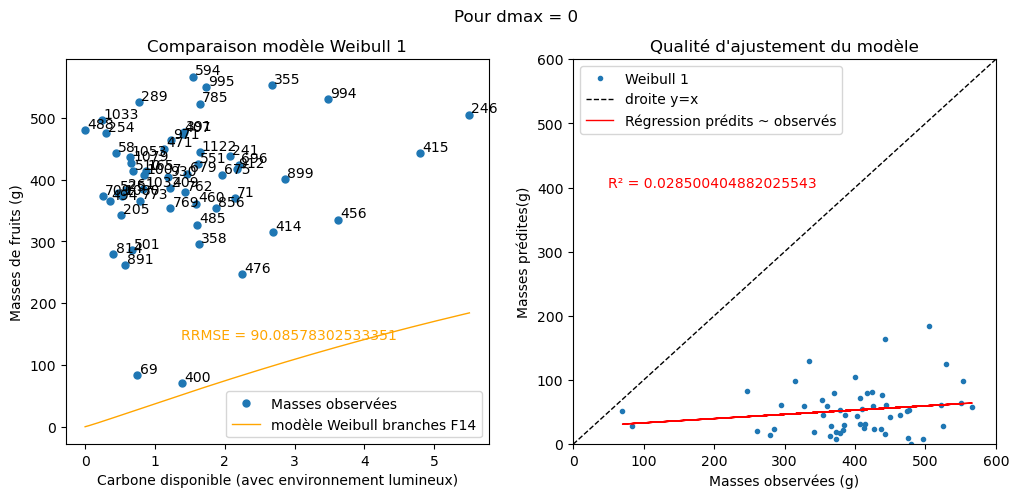

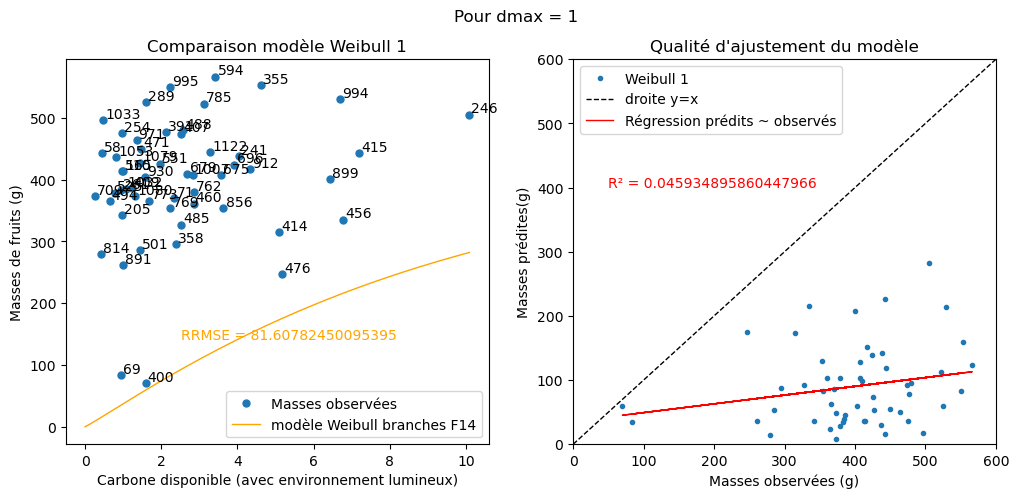

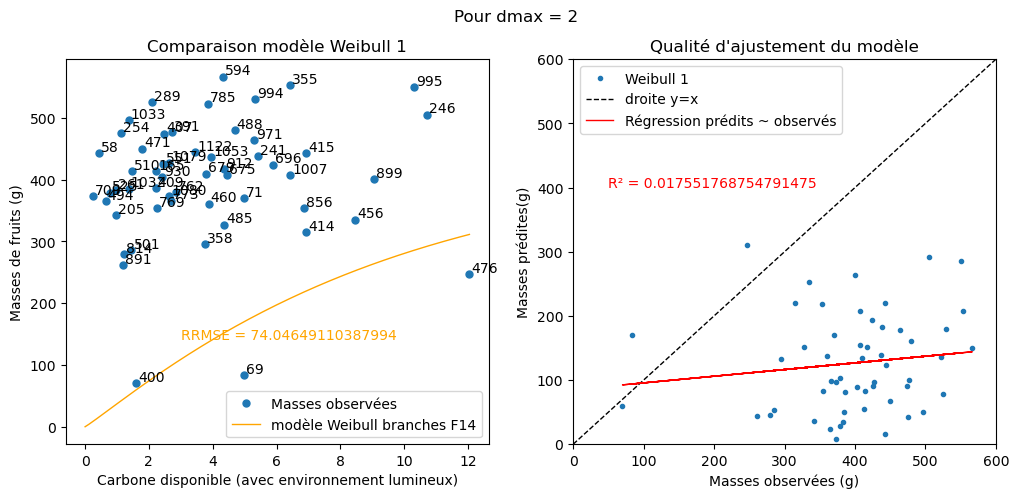

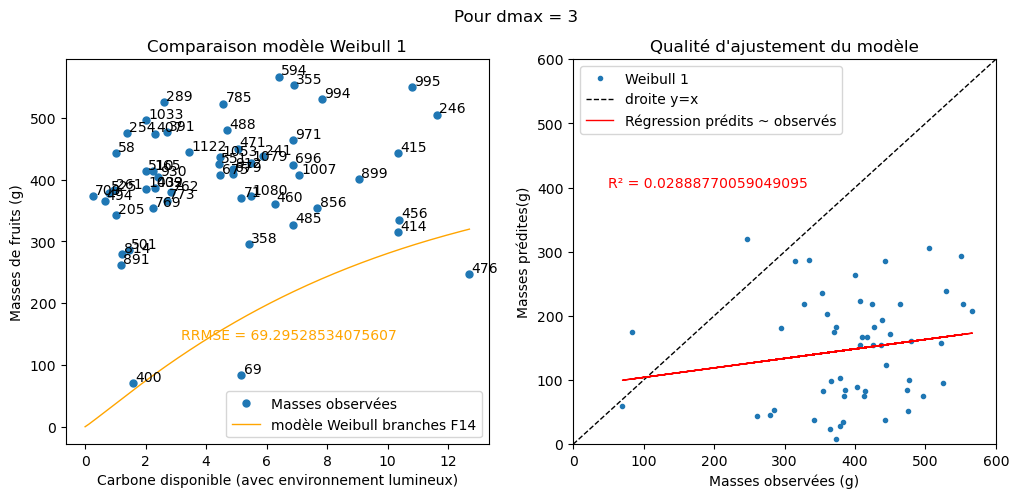

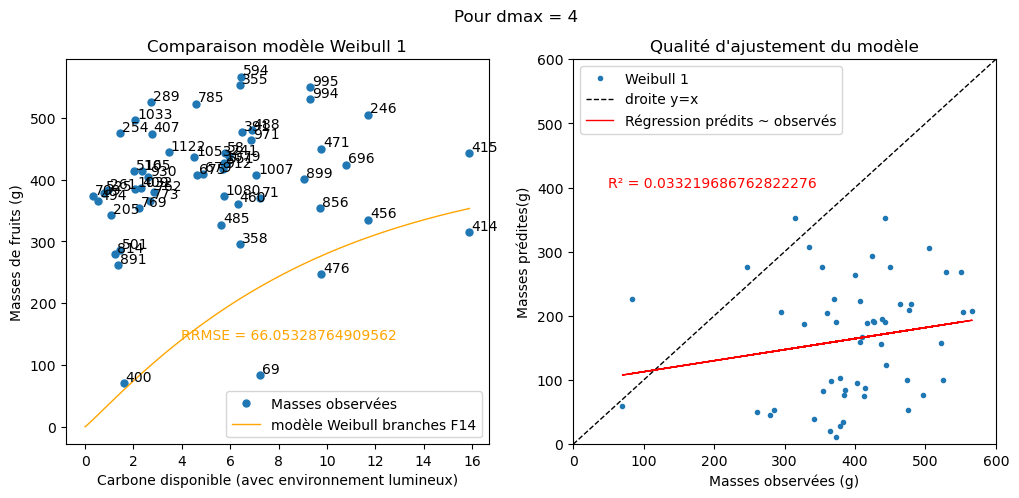

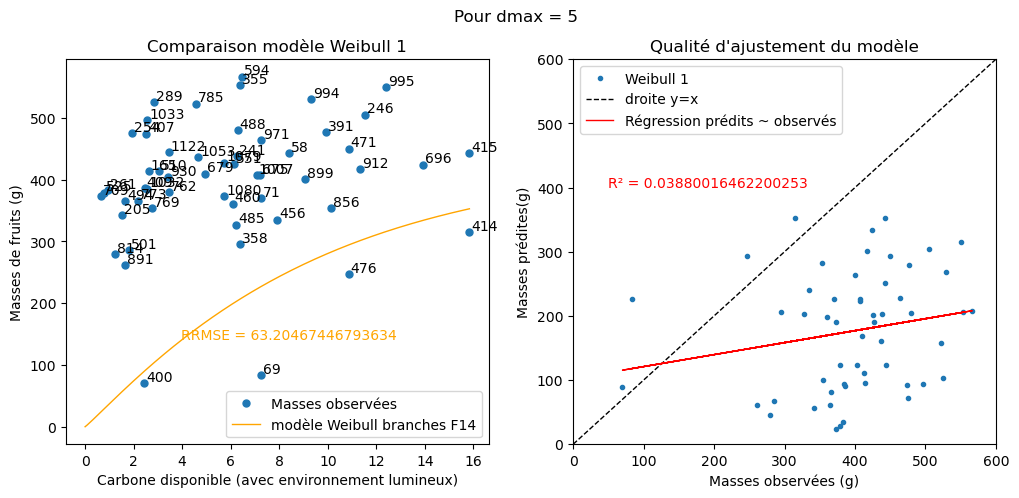

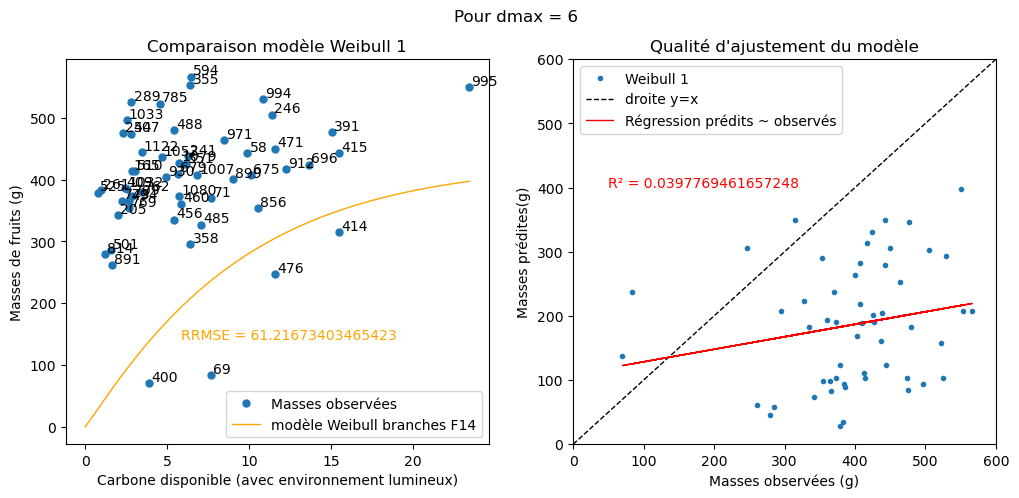

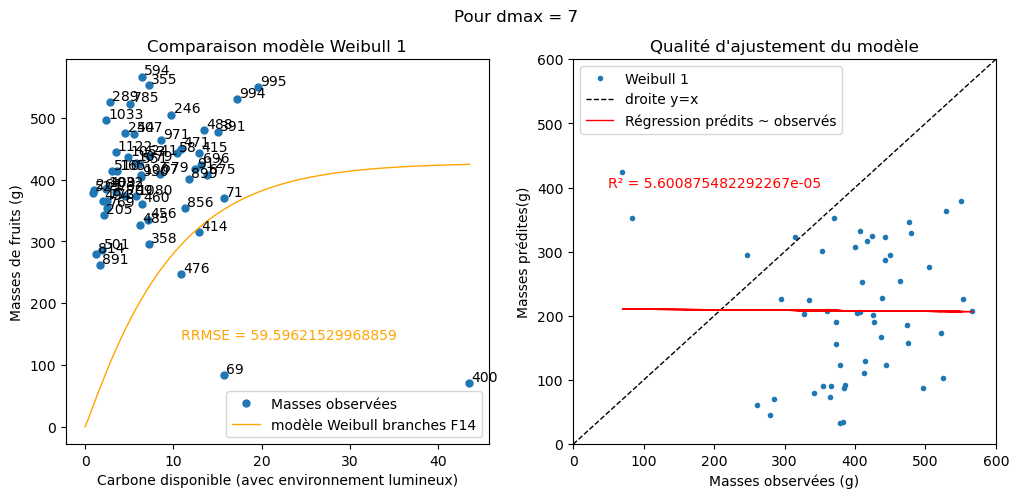

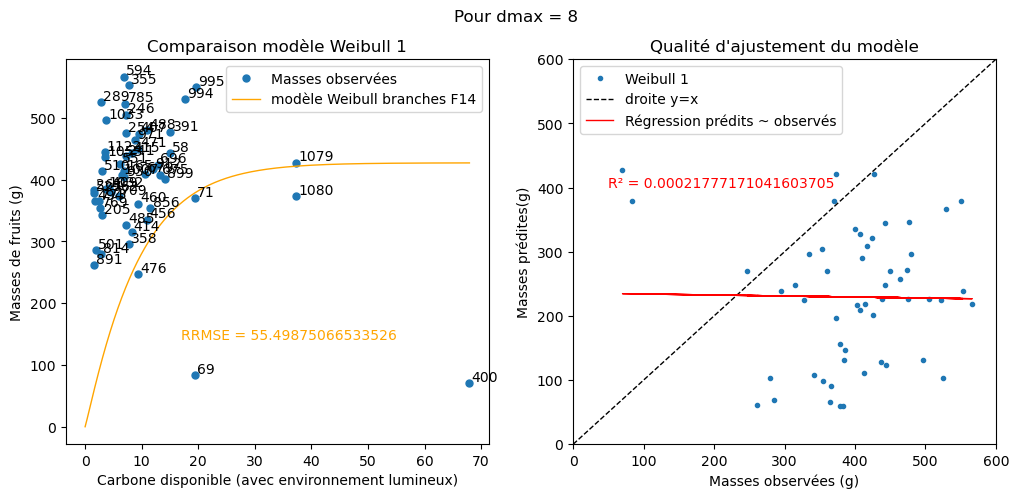

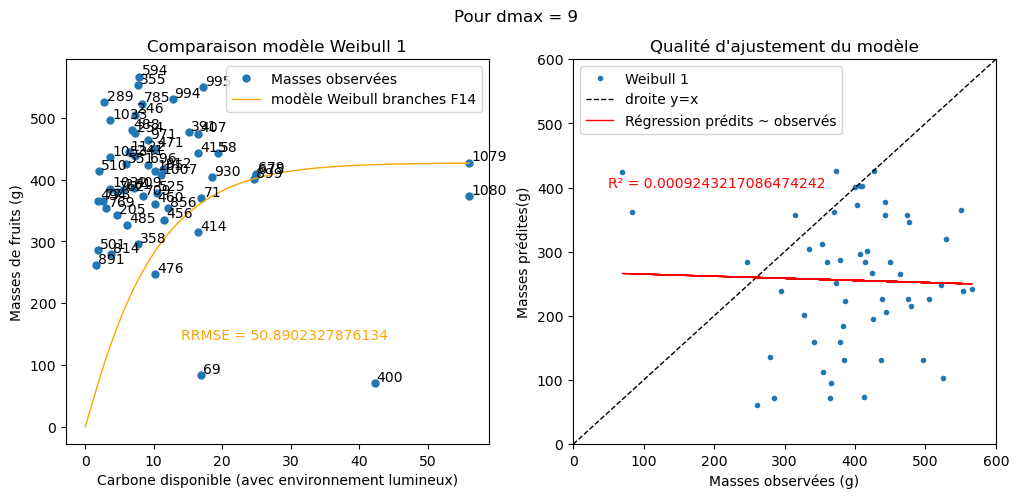

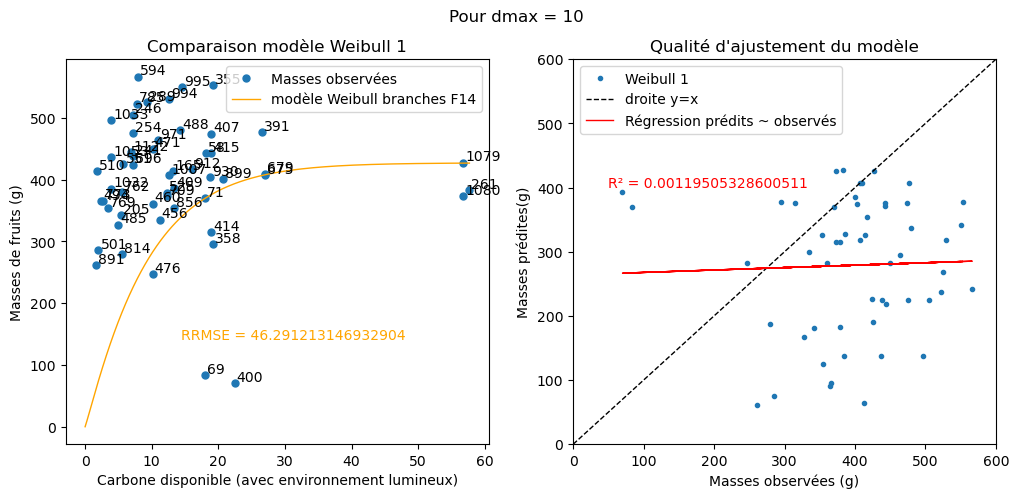

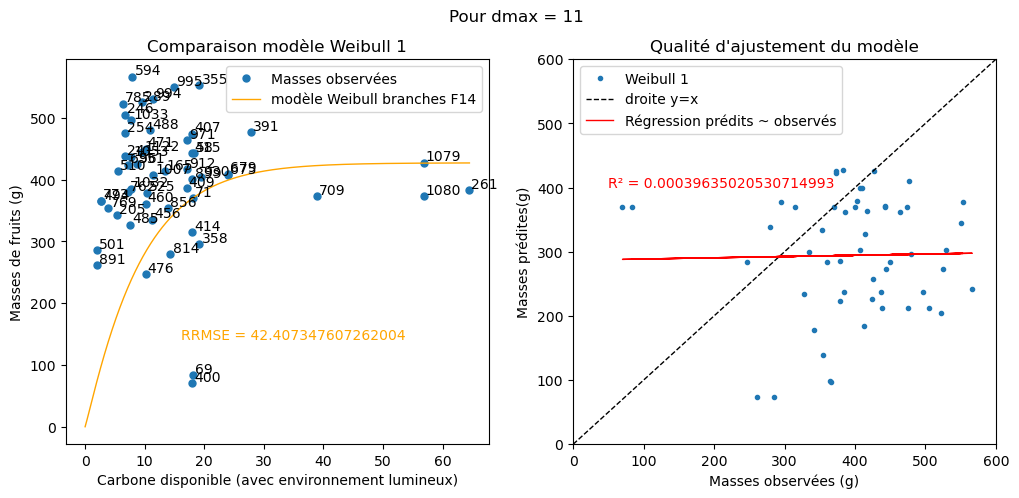

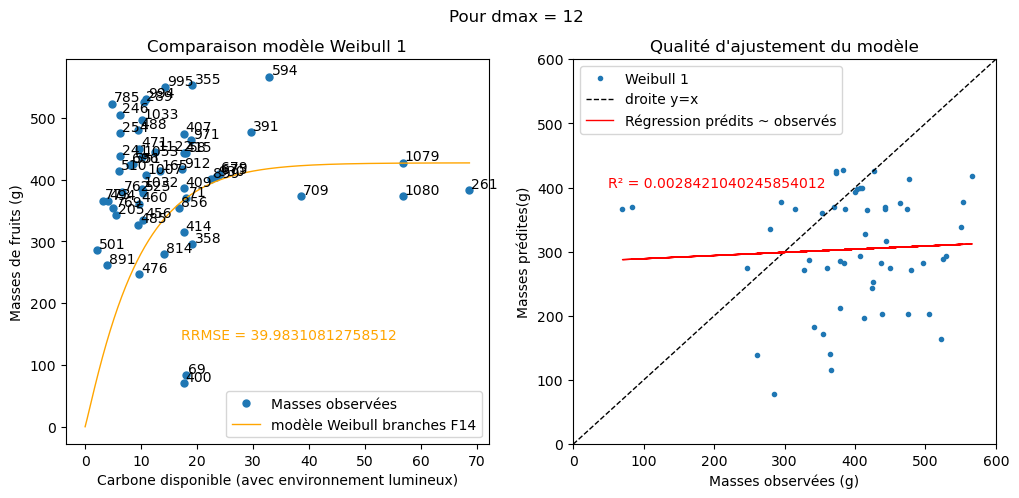

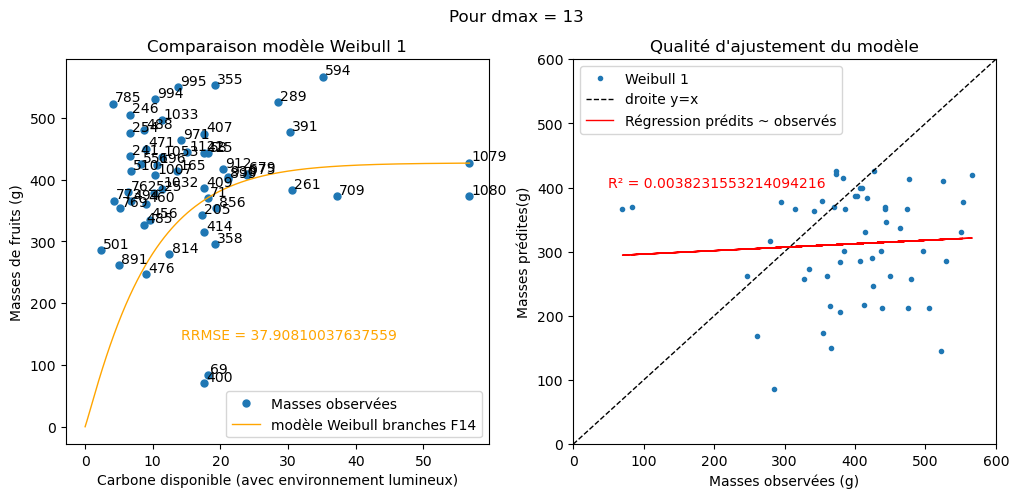

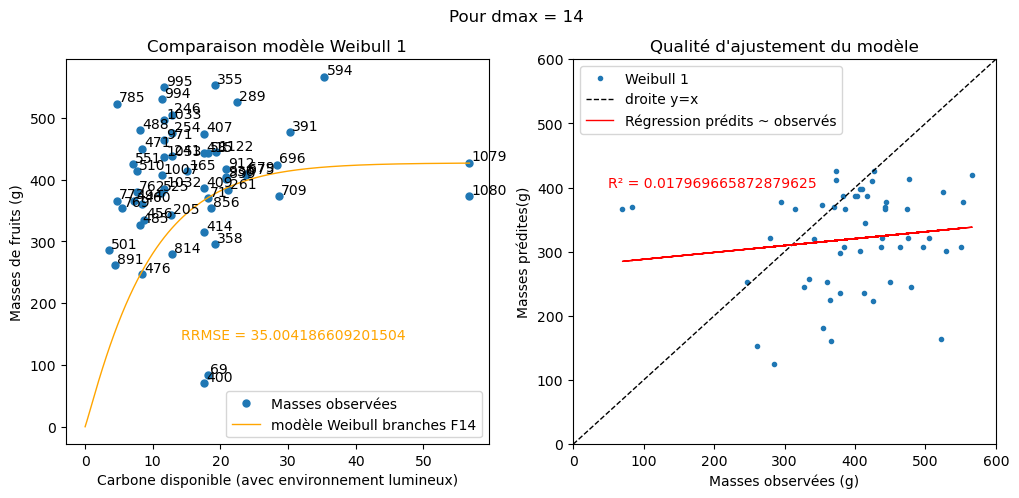

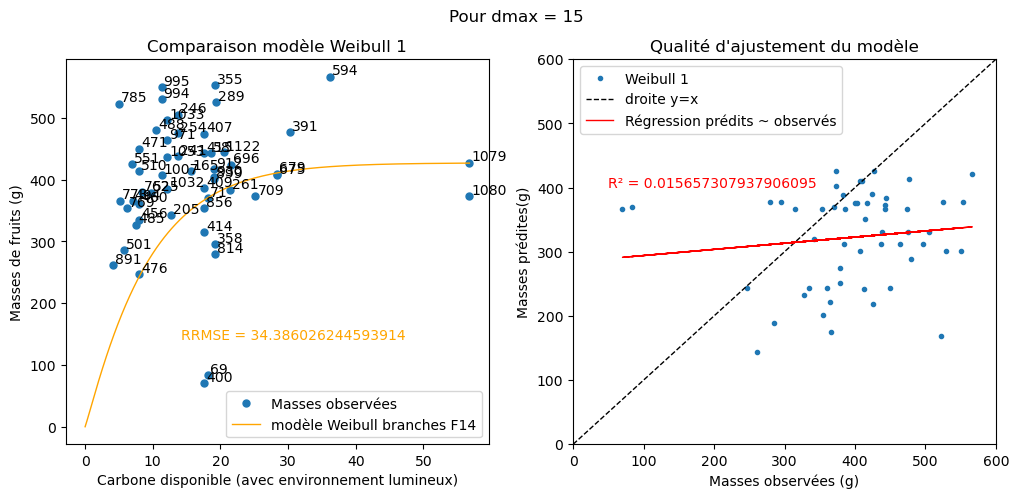

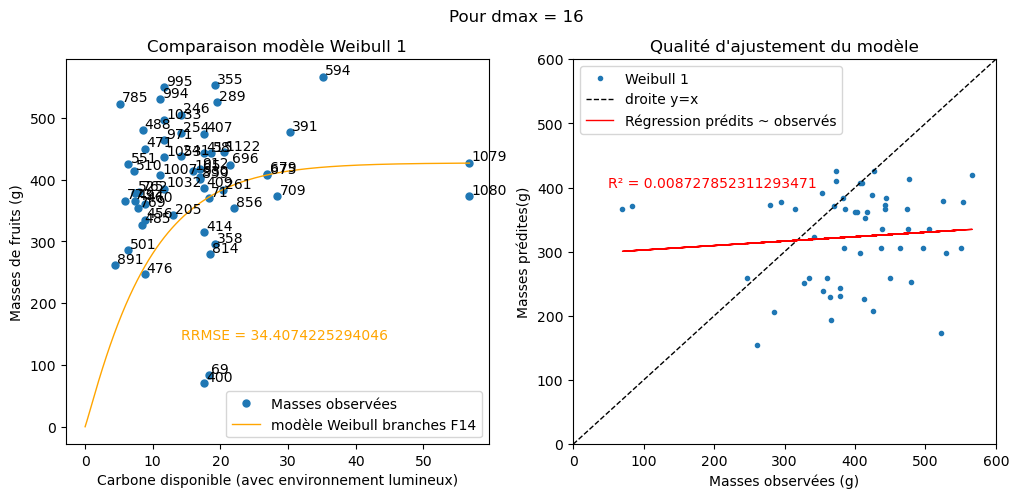

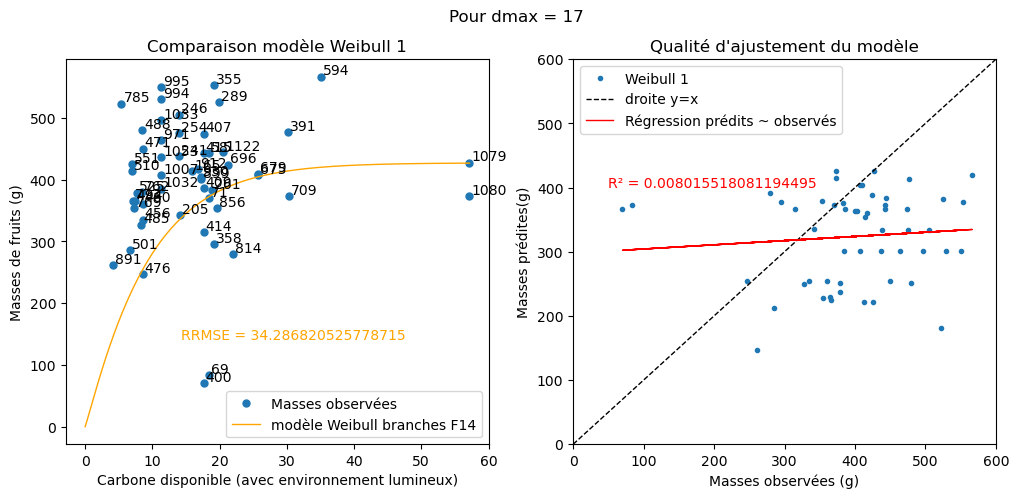

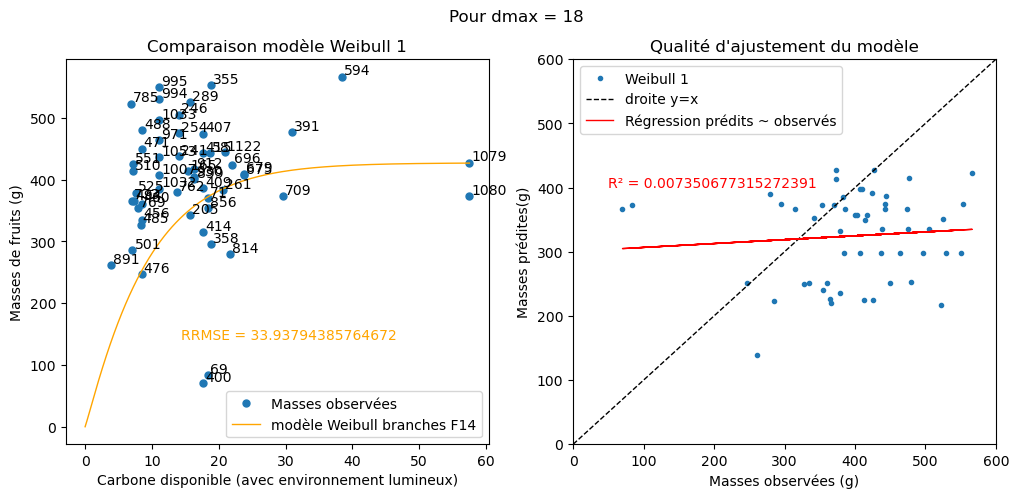

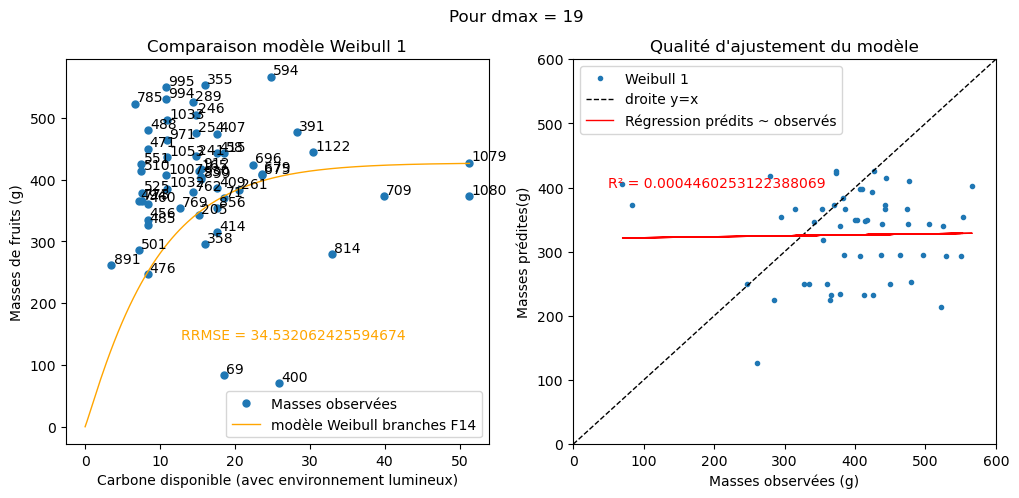

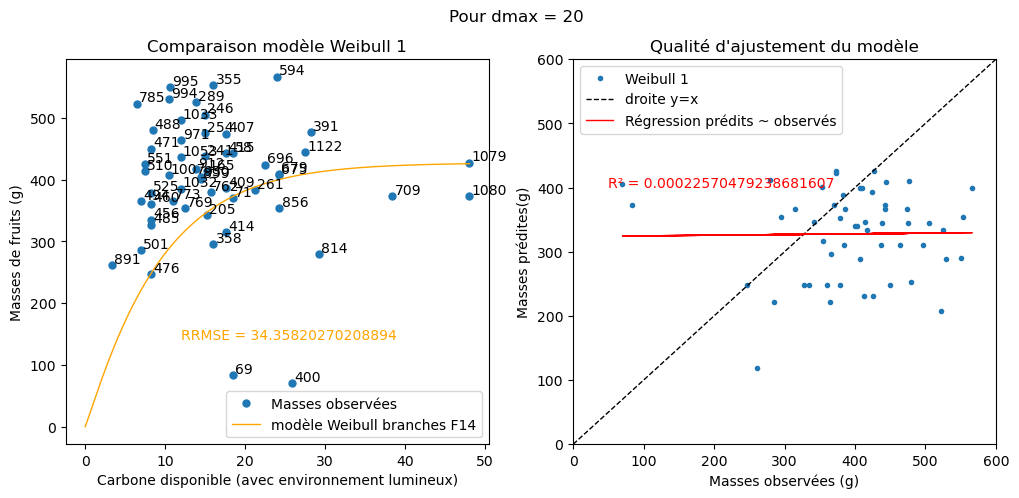

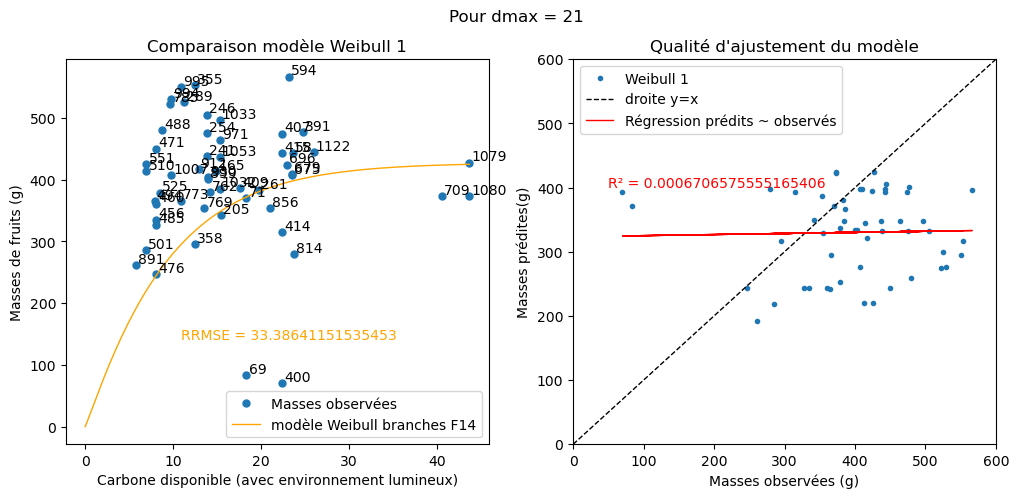

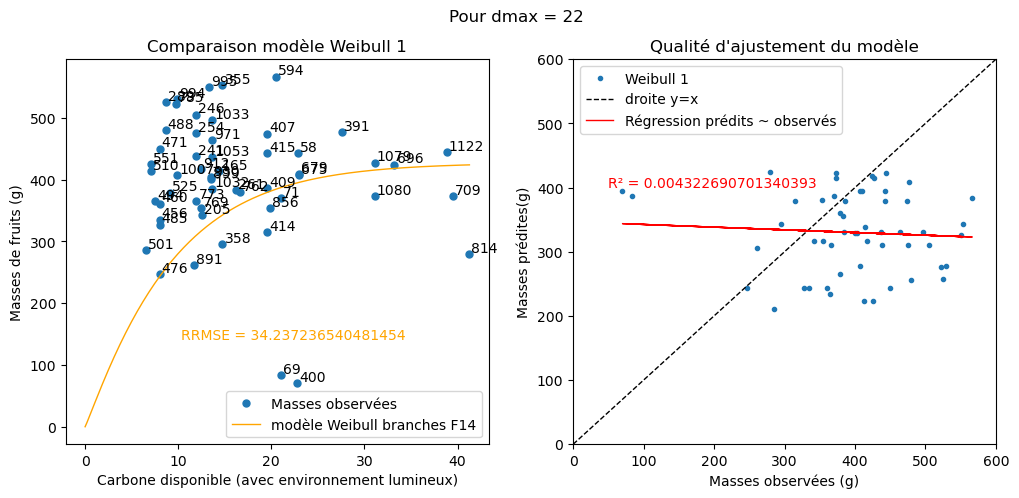

In [85]:
show_id_on_plot = True
rrmse = []
for i in  distances_range :
      x = final_table.loc['shared light carbon'].loc[i].astype(float)
      y1 = final_table.loc['fresh_mass',""].astype(float)
      y2= model_weibull(x, asym_ref, k_ref, pwr_ref)
      sample=pd.DataFrame({'x':x, 'y1':y1, 'y2':y2, 'dry_mass': final_table.loc['dry_mass','']}).astype(float)
      
      fig, axs = plt.subplots(ncols=2, nrows=1, figsize = (12,5))
      fig.suptitle("Pour dmax = "+str(i))

      sample.plot(x='x', y='y1',
            kind="line", title = "Comparaison modèle Weibull 1",
            linestyle="", marker=".",markersize=10,
            xlabel = 'Carbone disponible (avec environnement lumineux)', ylabel = 'Masses de fruits (g)',
            label = "Masses observées",
            ax = axs[0])
      if show_id_on_plot : 
            for xi, yi, text in zip(sample['x'], sample['y1'], sample.index):
                  axs[0].annotate(text, xy=(xi,yi), xycoords='data',
                              xytext=(1.5,1.5), textcoords='offset points')
      
      x = np.linspace(0, np.max(x),200)
      y= model_weibull(x, asym_ref, k_ref, pwr_ref)
      axs[0].plot(x,y, linestyle="-",linewidth=1,
                  color='orange', label='modèle Weibull branches F14')
      
      axs[0].text(x=np.max(sample['x'])/4, y=np.max(sample['y1'])/4, s= "RRMSE = "+ str(RRMSE(predicted = y2, observed = y1)), color='orange')
      axs[0].legend()

      rrmse.append(RRMSE(predicted = y2, observed = y1))
      sample.plot(x='y1', y='y2',
                  kind='line', title="Qualité d'ajustement du modèle",
                  linestyle='', marker='.',linewidth=1,
                  ax=axs[1], label = 'Weibull 1',
                  xlim =(0,600), ylim =(0,600),
                  xlabel = 'Masses observées (g)', ylabel = 'Masses prédites(g)')
      axs[1].plot([0,600],[0,600], color='black',linewidth=1, linestyle="--", label = 'droite y=x')
      axs[1].plot(sample['y1'], smf.ols('y2 ~ y1', data=sample).fit().predict(sample['y1']),
                  linewidth=1, label='Régression prédits ~ observés', color='red')
      axs[1].text(x=50, y=400, s= "R² = "+ str(smf.ols('y2 ~ y1', data=sample).fit().rsquared), color='red')
      axs[1].legend()

      # plt.close()

Text(0, 27, 'Fair')

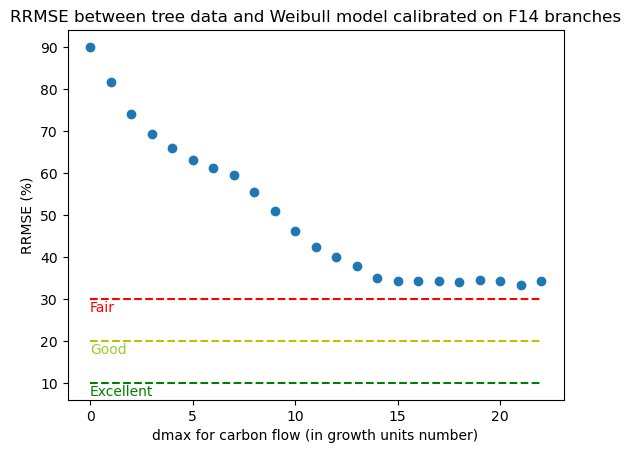

In [86]:
plt.scatter(distances_range, rrmse)
plt.title('RRMSE between tree data and Weibull model calibrated on F14 branches')
plt.xlabel('dmax for carbon flow (in growth units number)')
plt.ylabel('RRMSE (%)')
plt.plot([0,22], [10,10], 'g--')
plt.plot([0,22], [20,20], 'y--')
plt.plot([0,22], [30,30], 'r--')
plt.text(x=0, y=7, s="Excellent", c='green')
plt.text(x=0, y=17, s="Good", c='yellowgreen')
plt.text(x=0, y=27, s="Fair", c='red')

Conclusion : Le modèle calibré sur les branches annelées n'est pas satisfaisant pour expliquer les masses des fruits des arbres E13, E16, et G3, quelque soit la distance fixée.

## Visualise carbon flows

In [87]:
carbon_flows = get_var_fruit_growth(tree, dmax=12, year_sunlit_fractions= sunlit_fraction_df, with_successors=False, see_carbon_flow=True)[2]
carbon_flows_df = pd.DataFrame(carbon_flows, index=np.flatnonzero(tree['arch_dev__pot_nb_fruit']>0))
carbon_flows_df.index.name = 'Fruit id'
carbon_flows_df.columns.name = 'Source id'
carbon_flows_df

C:\Users\bolot\AppData\Local\Temp\ipykernel_22404\3970760918.py:81: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number


Source id  0     1     2     3     4     5     6     7     8     9     ...  \
Fruit id                                                               ...   
58          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
69          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
71          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
165         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
173         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
1072        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1073        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1079        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1080        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1122        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

Source id  1130  1131      1132  1133      1134      1135  1136      1137  \
Fruit id                                                                    
58          0.0   0.0  0.000000   0.0  0.000000  0.000000   0.0  0.000000   
69          0.0   0.0  0.000000   0.0  0.000000  0.000000   0.0  0.000000   
71          0.0   0.0  0.000000   0.0  0.000000  0.000000   0.0  0.000000   
165         0.0   0.0  0.000000   0.0  0.000000  0.000000   0.0  0.000000   
173         0.0   0.0  0.000000   0.0  0.000000  0.000000   0.0  0.000000   
...         ...   ...       ...   ...       ...       ...   ...       ...   
1072        0.0   0.0  0.000000   0.0  0.000000  0.000000   0.0  0.000000   
1073        0.0   0.0  0.000000   0.0  0.000000  0.000000   0.0  0.000000   
1079        0.0   0.0  0.000000   0.0  0.000000  0.000000   0.0  0.000000   
1080        0.0   0.0  0.000000   0.0  0.000000  0.000000   0.0  0.000000   
1122        0.0   0.0  0.360417   0.0  0.901042  1.441667   0.0  0.093083   

Source id     1138  1139  
Fruit id                  
58         0.00000   0.0  
69         0.00000   0.0  
71         0.00000   0.0  
165        0.00000   0.0  
173        0.00000   0.0  
...            ...   ...  
1072       0.00000   0.0  
1073       0.00000   0.0  
1079       0.00000   0.0  
1080       0.00000   0.0  
1122       0.27925   0.0  

[63 rows x 1140 columns]

In [88]:
# example : carbon flow drom GU 25 to each fruit
carbon_flows_df[25]

Fruit id
58      0.06
69      0.06
71      0.06
165     0.00
173     0.00
        ... 
1072    0.00
1073    0.00
1079    0.00
1080    0.00
1122    0.00
Name: 25, Length: 63, dtype: float64

## Further researches on the tree

Since results were not very clear after plotting the variables on R, further researches are led.

In [89]:
from math import ceil

### Fruit mass

In [90]:
fruit_mass.sort_values("MF_rec")

id_branche    MS_ini   MF_rec
id_UC                               
400.0        14.0       NaN   70.000
69.0          3.0       NaN   83.000
622.0        20.0       NaN  231.000
476.0         9.0       NaN  247.000
891.0        26.0  5.167755  260.910
...           ...       ...      ...
289.0         7.0  7.564448  525.070
994.0        31.0  6.283677  529.590
995.0        31.0       NaN  550.000
355.0        16.0  6.224352  553.230
594.0        19.0  9.164042  566.365

[64 rows x 3 columns]

In [91]:
fruit_mass.describe()

id_branche     MS_ini      MF_rec
count   64.000000  34.000000   64.000000
mean    18.109375   6.504922  392.759557
std     10.554646   1.356807   94.018094
min      1.000000   4.695123   70.000000
25%      9.000000   5.589909  353.898750
50%     16.000000   6.190099  404.775000
75%     27.000000   7.166214  443.402500
max     37.000000  11.380306  566.365000

<Axes: xlabel='Masse du fruit (g)', ylabel='nombre de fruits'>

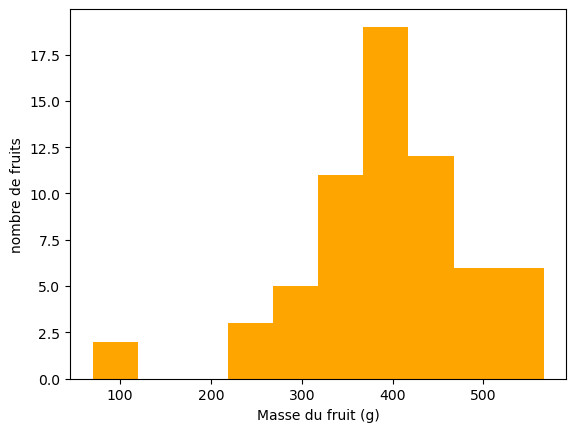

In [92]:
fruit_mass['MF_rec'].plot(kind="hist", ylabel = "nombre de fruits", xlabel="Masse du fruit (g)", color="orange")

Branches are created from each fruit, and are defined as the group of GU at the d distance of this fruit. Dupplicates are droped, and non proper grotwh units (branch, branch empty...) are removed as well.

In [93]:
def collect_branches (tree, dmax, drop_dupplicate = False):
    graph = vmlab.to_graph(tree)
    adjacency = np.array(graph.get_adjacency())
    is_fruting = (tree['arch_dev__pot_nb_fruit'] > 0)

    # Initializaton
    distance_to_fruit = np.array([], dtype=np.float32)
    is_in_distance_to_fruit = np.array([], dtype=bool)

    # Collecting GUs (fruit GU included)
    if np.any(is_fruting) : 
        distance_to_fruit = csgraph.shortest_path( 
                                    adjacency,
                                    indices=np.flatnonzero(is_fruting),
                                    directed=False
                                ).astype(np.float32)

        distance_to_fruit[distance_to_fruit > dmax] = np.inf #collecting GU under a dmax distance
        is_in_distance_to_fruit = np.isfinite(distance_to_fruit).astype(np.float32) 
        is_in_distance_to_fruit[is_in_distance_to_fruit==0] = np.nan

        fruit_mass_of_reachable_GU = pd.DataFrame(np.copy(is_in_distance_to_fruit).astype(float), index=np.flatnonzero(is_fruting))
        
    for i in range (0, graph.ecount()):
        if i in fruit_mass.index:
            fruit_mass_of_reachable_GU.loc[fruit_mass_of_reachable_GU[i]==1,i] = fruit_mass.loc[i,"MF_rec"]
    fruit_mass_of_reachable_GU[fruit_mass_of_reachable_GU==1] = np.nan
    fruit_mass_of_reachable_GU["type"] = tree.loc[tree['arch_dev__pot_nb_fruit'] >0]['type']
    if drop_dupplicate == True :
        fruit_mass_of_reachable_GU.drop_duplicates(inplace=True, keep="first")
    fruit_mass_of_reachable_GU.drop(labels = [i for i in fruit_mass_of_reachable_GU.index if i not in fruit_mass.index], inplace=True)
    #fruit_mass_of_reachable_GU.drop(labels = [i for i in fruit_mass_of_reachable_GU.index if fruit_mass_of_reachable_GU.loc[i, "type"]!="GU"], inplace=True)
    fruit_mass_of_reachable_GU.drop(columns="type", inplace=True)

    return np.transpose(fruit_mass_of_reachable_GU)

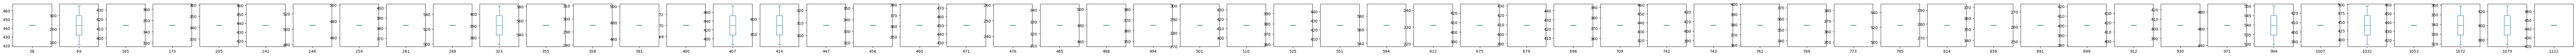

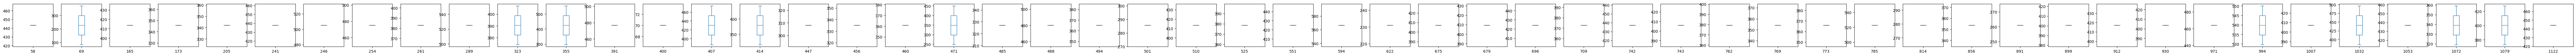

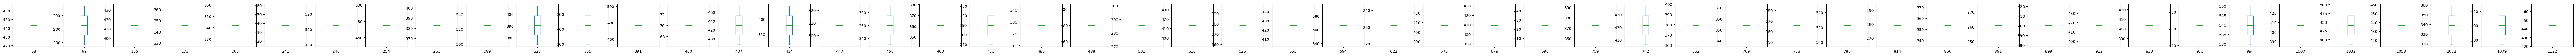

In [94]:
for branch_size in range (3,6):
    test = collect_branches(tree, branch_size, drop_dupplicate= True)
    test.plot(kind="box", subplots=True, figsize=(120,2))

/!\ On ne peut accéder à une branche que par le plus petit fruit contenu dans cette branche si on supprime les doublons

In [95]:
graph.ecount()

1139

In [96]:
from_tree = pd.DataFrame([collect_branches(tree, i, drop_dupplicate=True).std() for i in range (35,0,-1)], index = [i for i in range (35,0,-1)] ) 
from_tree["mean deviation"] = np.mean(from_tree, axis=1)

<Axes: title={'center': 'Moyenne des écarts types des masses de fruits des branches formées par chaque distance d'}, xlabel="longueur de la branche (en nombre d'UC)", ylabel='Moyenne des écarts types'>

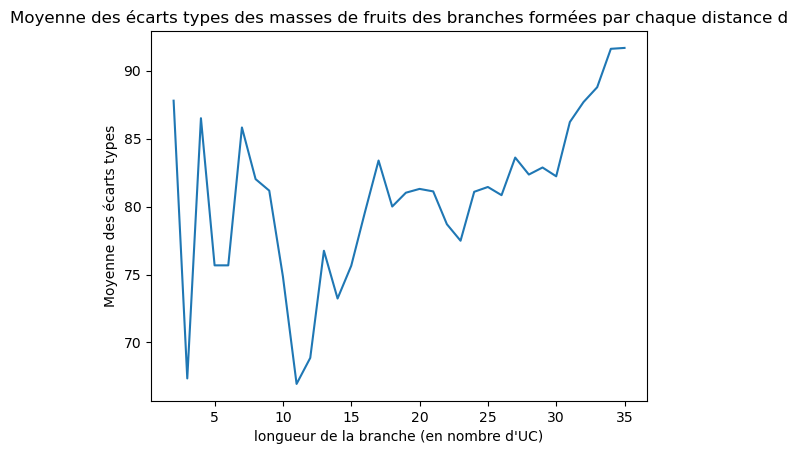

In [97]:
from_tree["mean deviation"].plot(title = "Moyenne des écarts types des masses de fruits des branches formées par chaque distance d", xlabel="longueur de la branche (en nombre d'UC)", ylabel="Moyenne des écarts types")

L'écart type moyen entre les masses des fruits est minimal pour d = 3 la longueur de la branche. Quand les branches se supperposent potentiellement, et ne tiennent pas compte du "type".

L'écart type moyen entre les masses des fruits est minimal pour d = 5 quand on supprime les doublons.

In [98]:
from_tree[from_tree["mean deviation"] == np.min(from_tree["mean deviation"])].index

Index([11], dtype='int64')

array([<Axes: title={'center': '58'}>, <Axes: title={'center': '69'}>,
       <Axes: title={'center': '165'}>, <Axes: title={'center': '173'}>,
       <Axes: title={'center': '205'}>, <Axes: title={'center': '241'}>,
       <Axes: title={'center': '261'}>, <Axes: title={'center': '323'}>,
       <Axes: title={'center': '330'}>, <Axes: title={'center': '355'}>,
       <Axes: title={'center': '400'}>, <Axes: title={'center': '407'}>,
       <Axes: title={'center': '447'}>, <Axes: title={'center': '456'}>,
       <Axes: title={'center': '488'}>, <Axes: title={'center': '494'}>,
       <Axes: title={'center': '594'}>, <Axes: title={'center': '622'}>,
       <Axes: title={'center': '675'}>, <Axes: title={'center': '709'}>,
       <Axes: title={'center': '742'}>, <Axes: title={'center': '762'}>,
       <Axes: title={'center': '769'}>, <Axes: title={'center': '773'}>,
       <Axes: title={'center': '785'}>, <Axes: title={'center': '856'}>,
       <Axes: title={'center': '912'}>, <Axes: title=

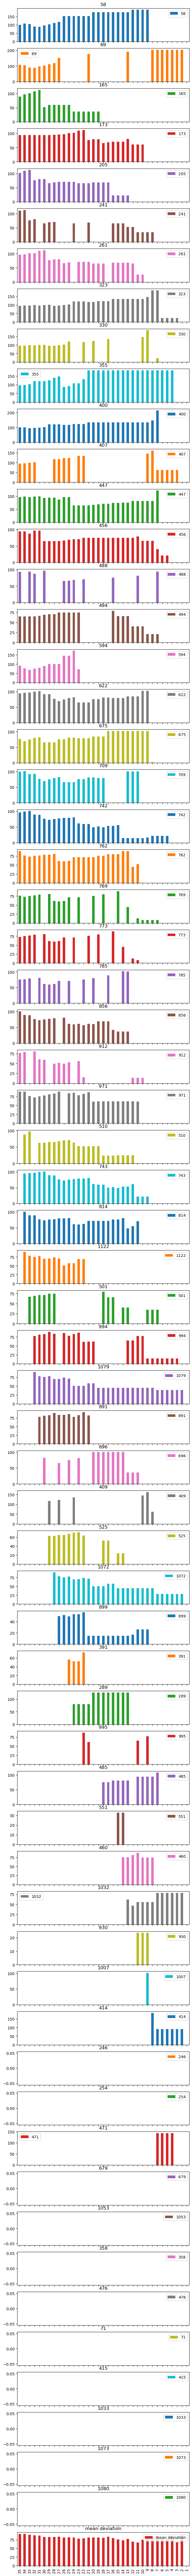

In [99]:
from_tree.plot(subplots=True, kind="bar", figsize=(8,120))

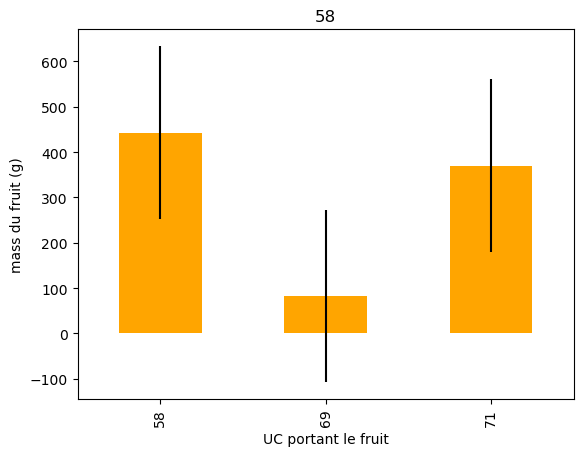

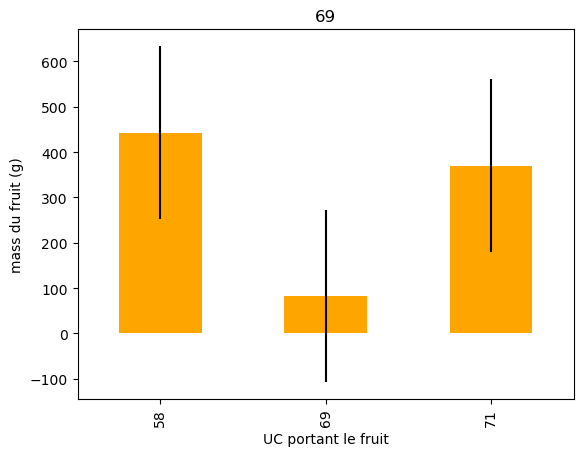

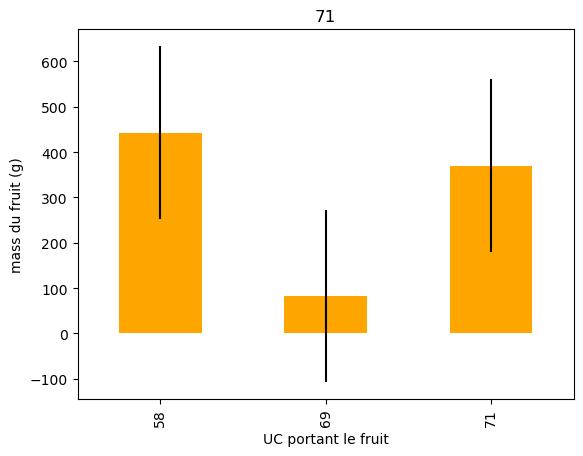

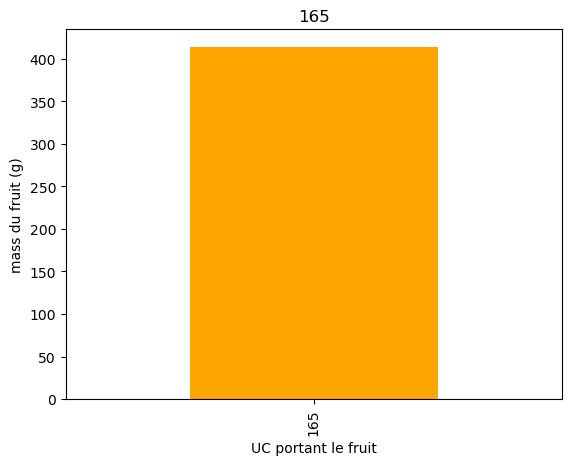

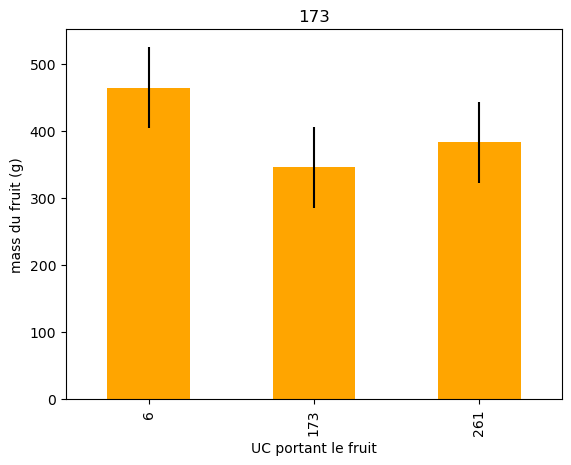

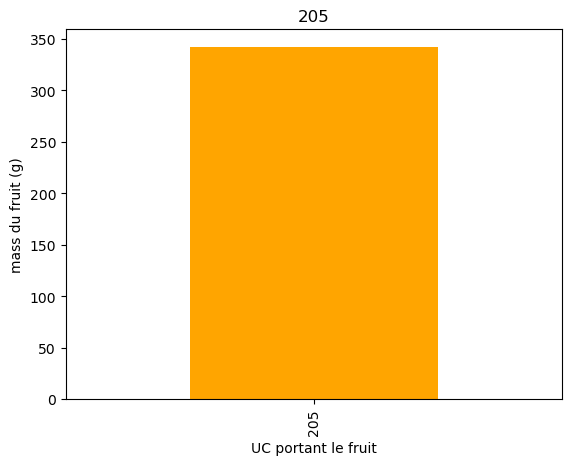

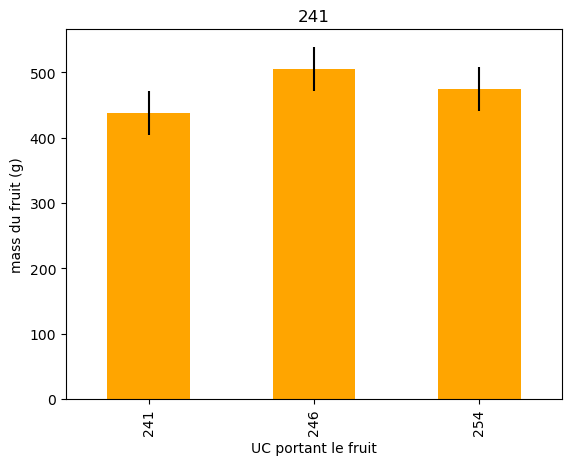

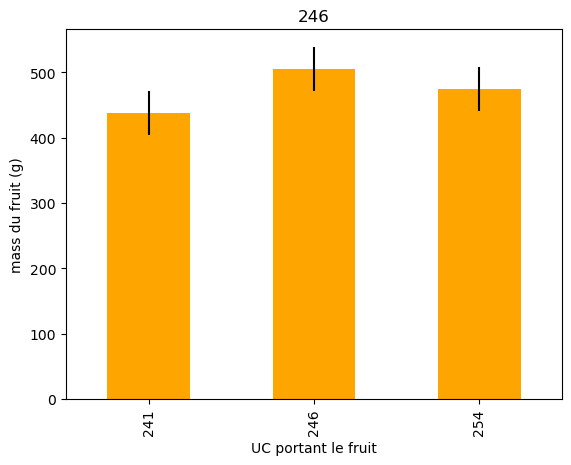

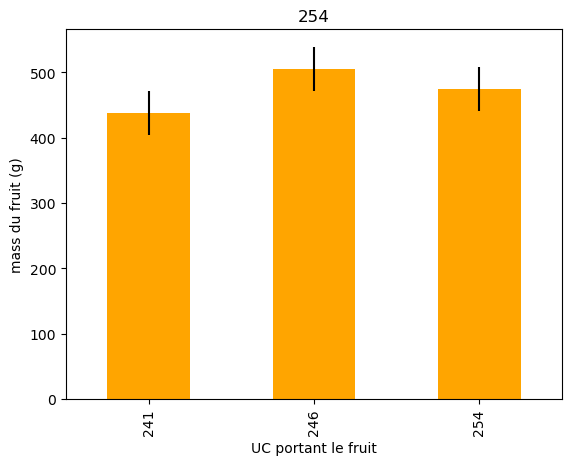

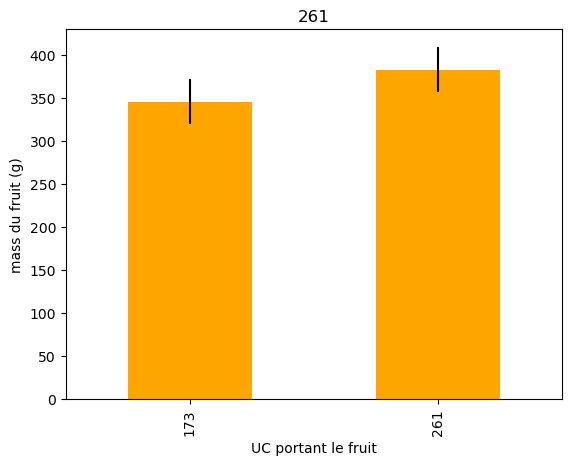

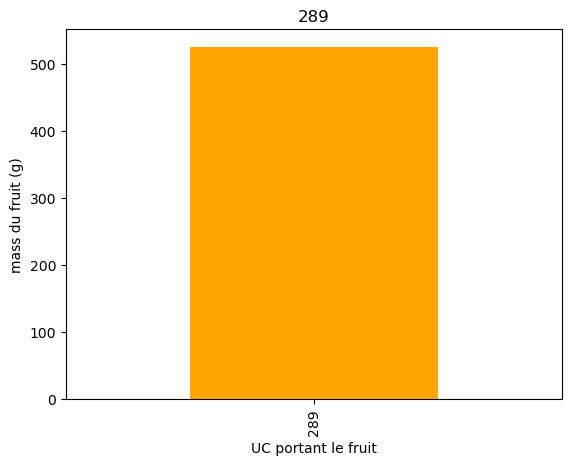

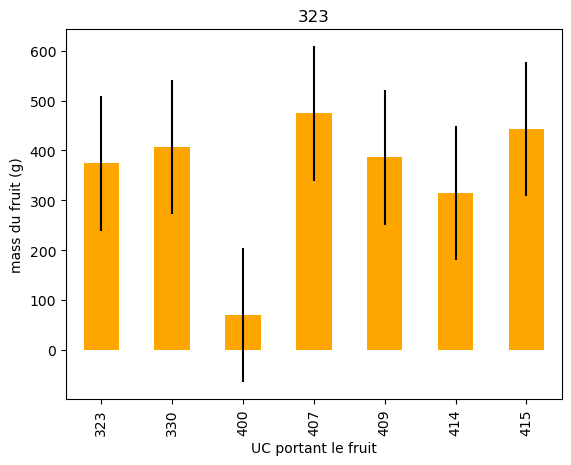

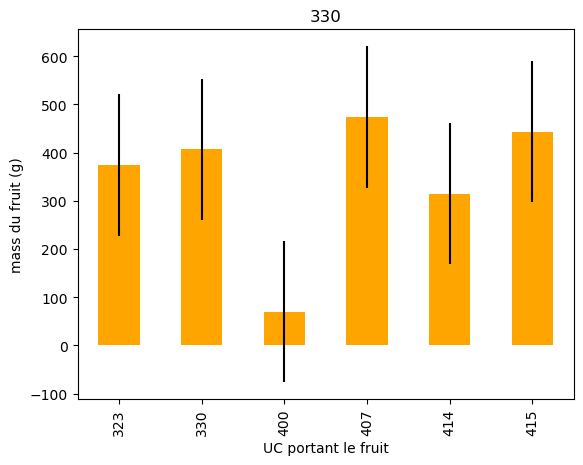

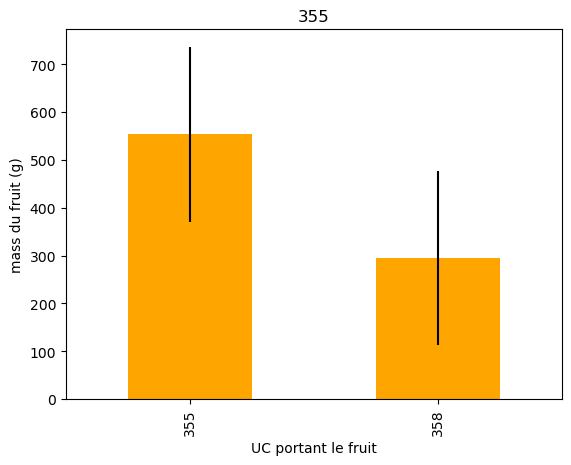

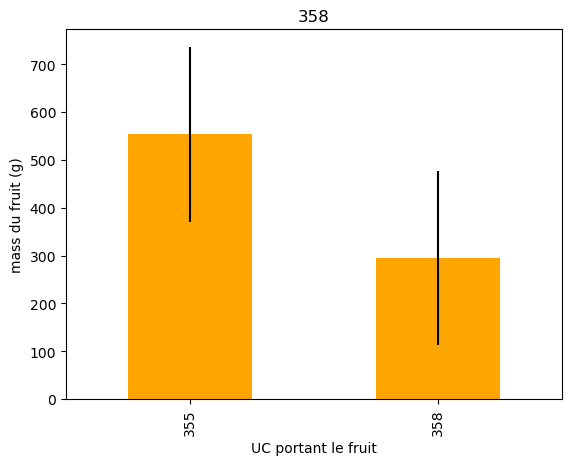

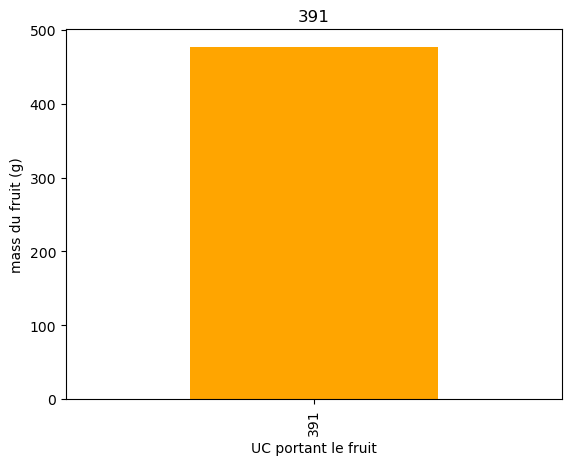

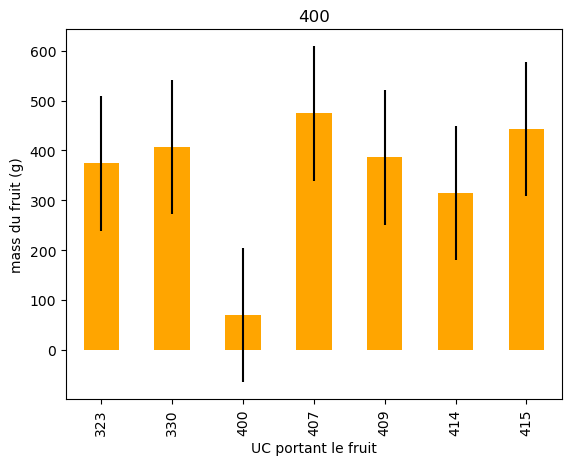

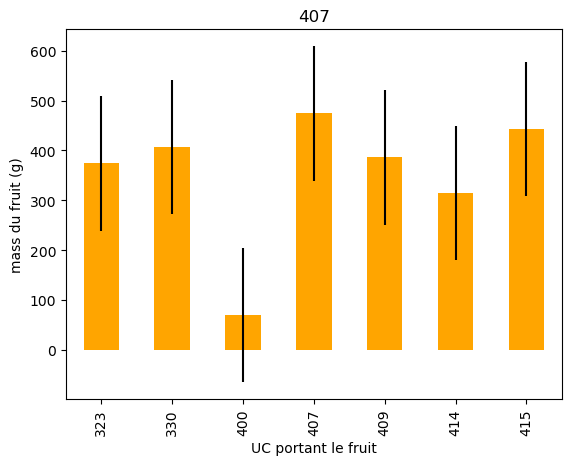

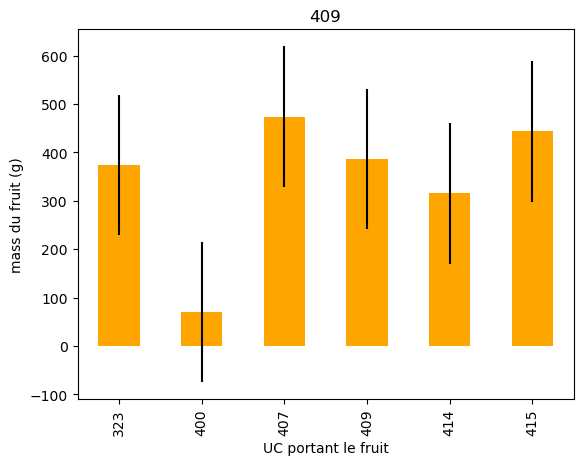

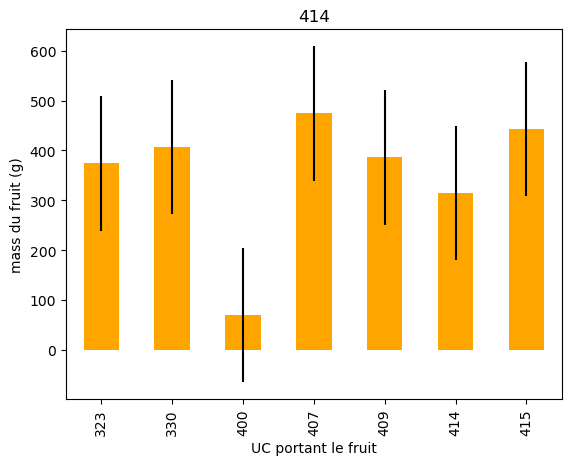

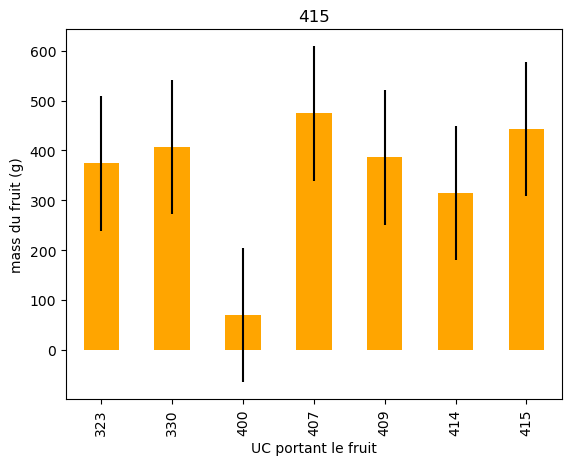

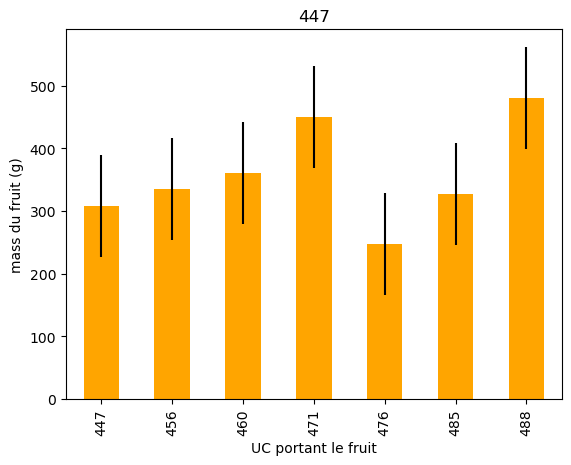

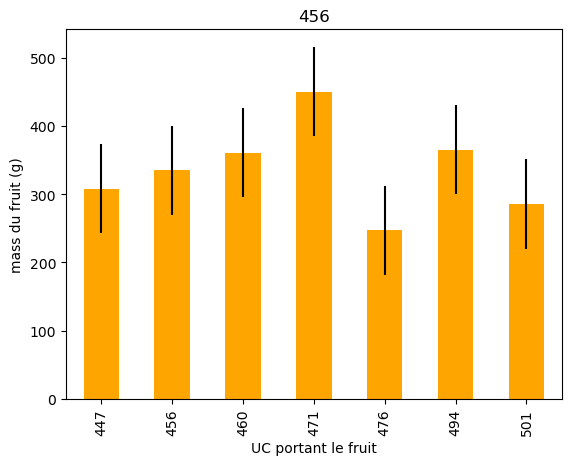

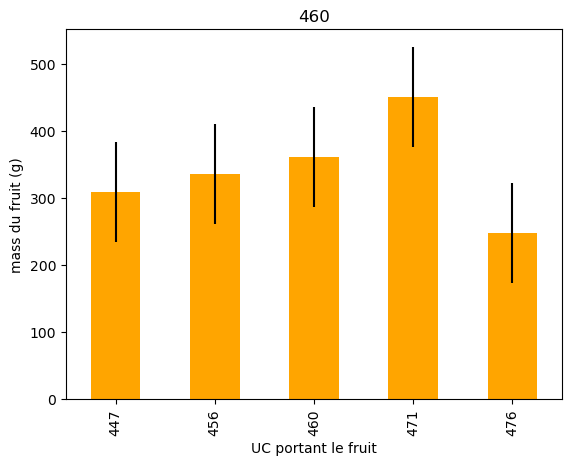

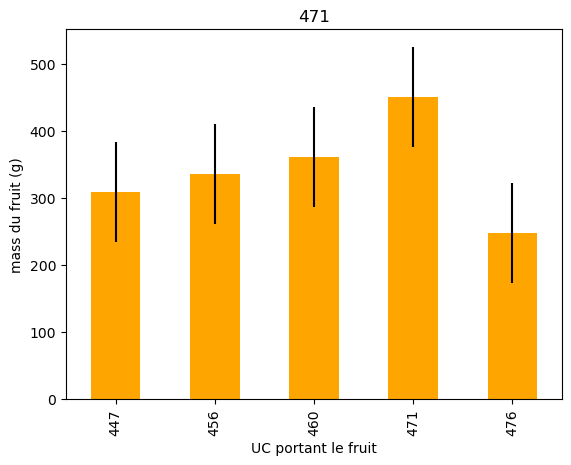

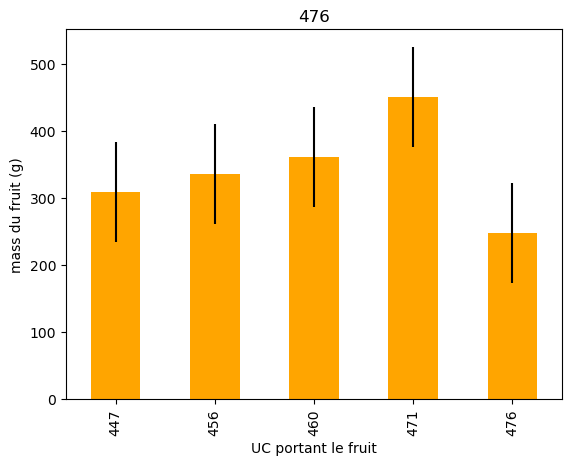

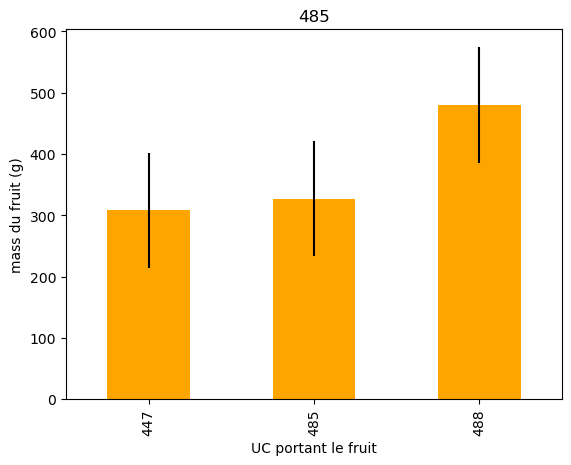

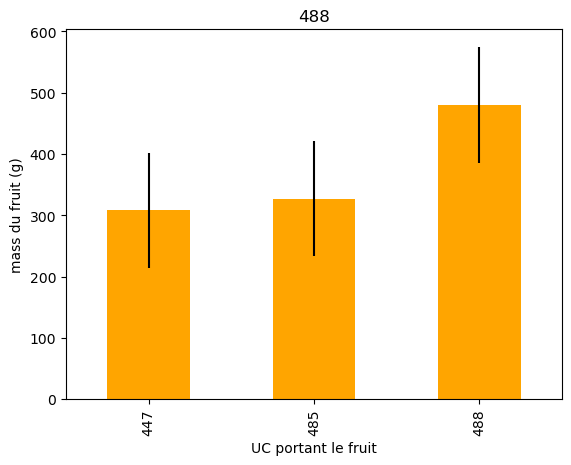

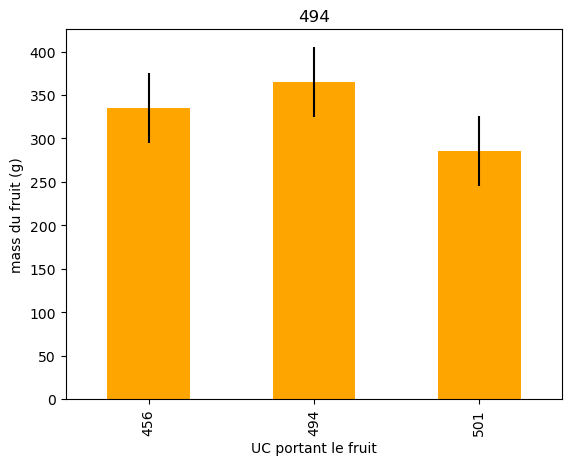

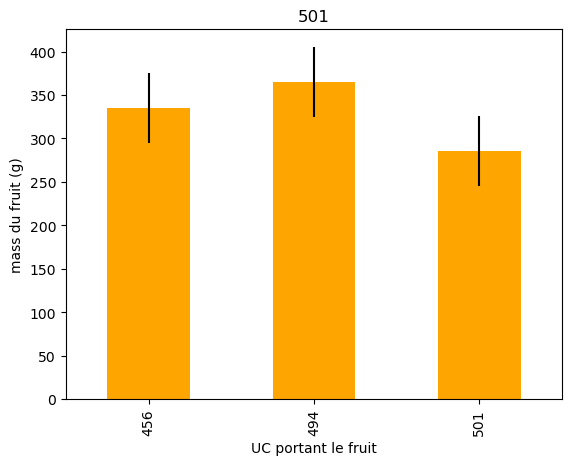

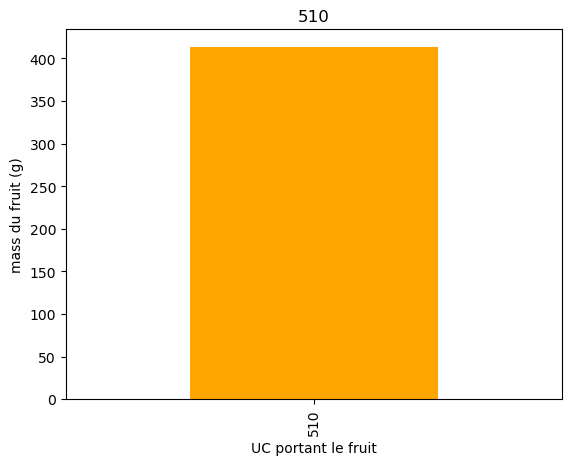

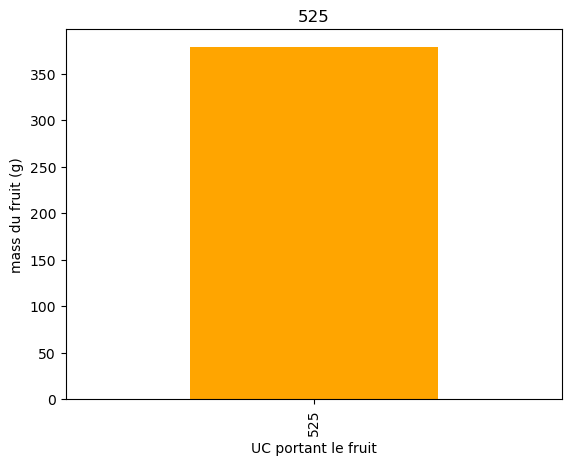

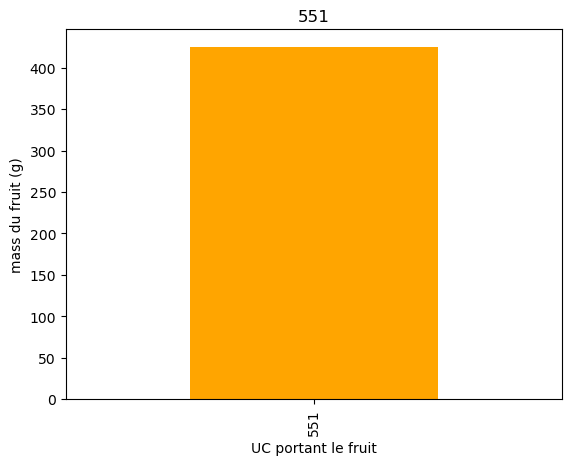

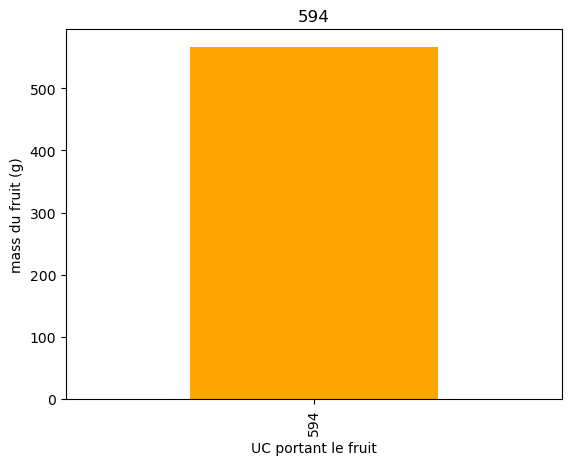

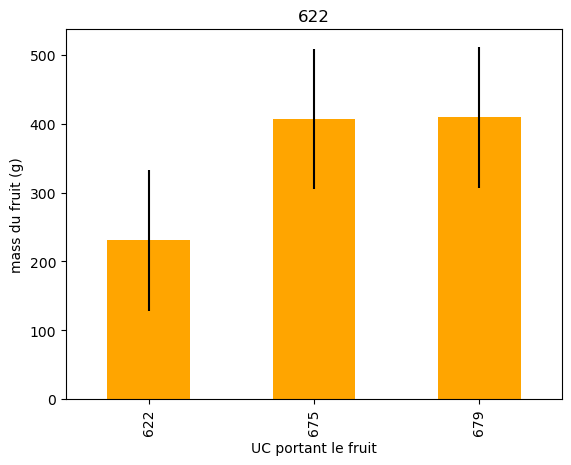

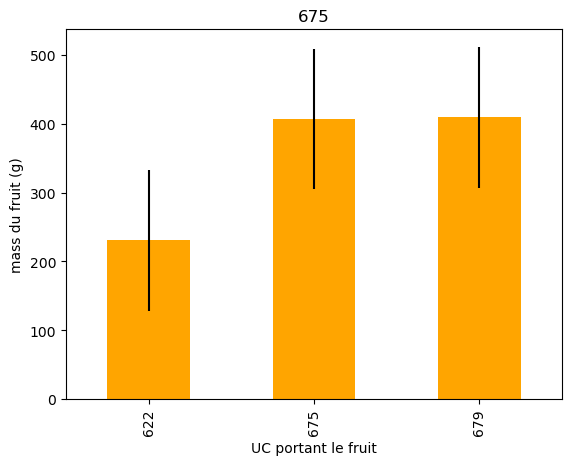

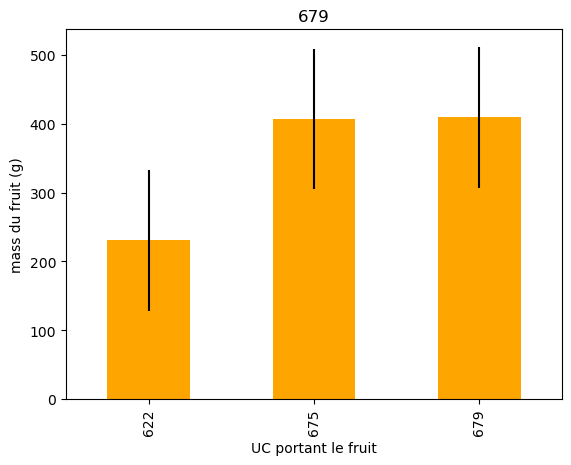

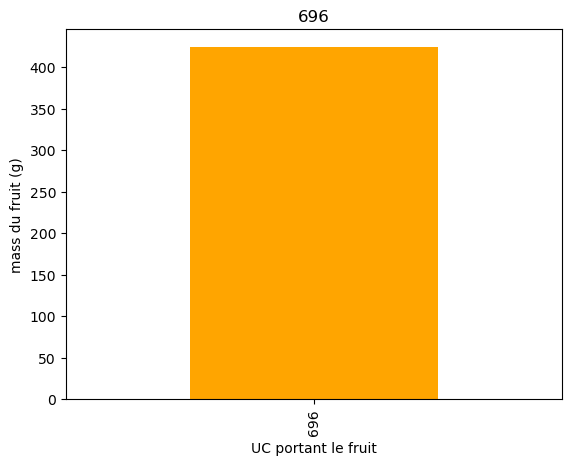

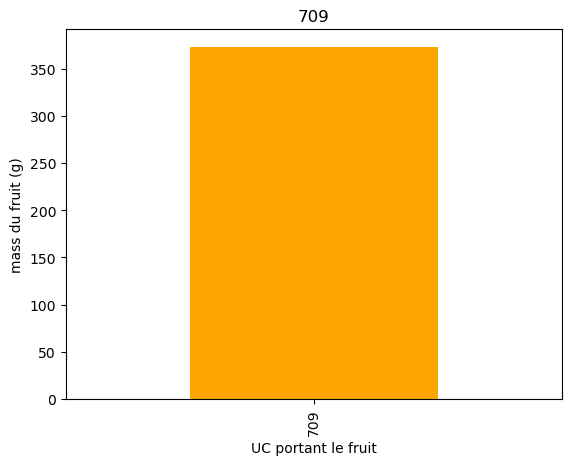

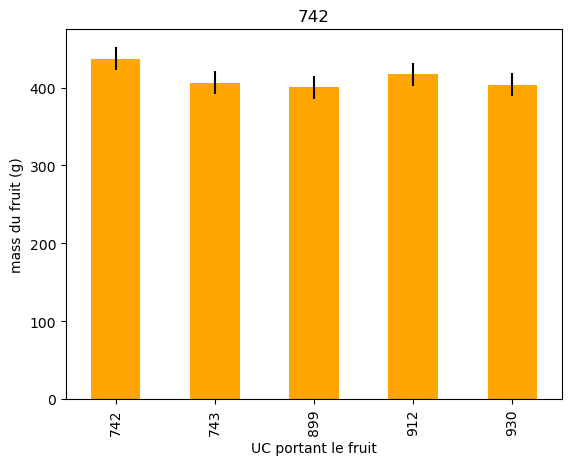

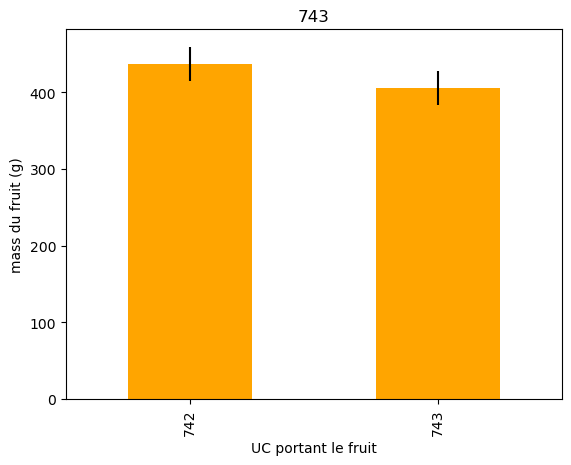

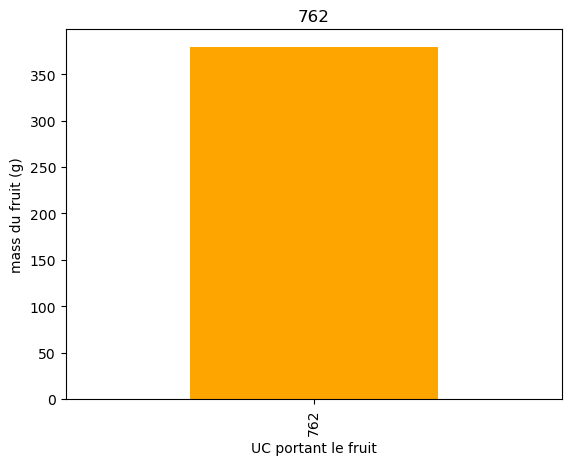

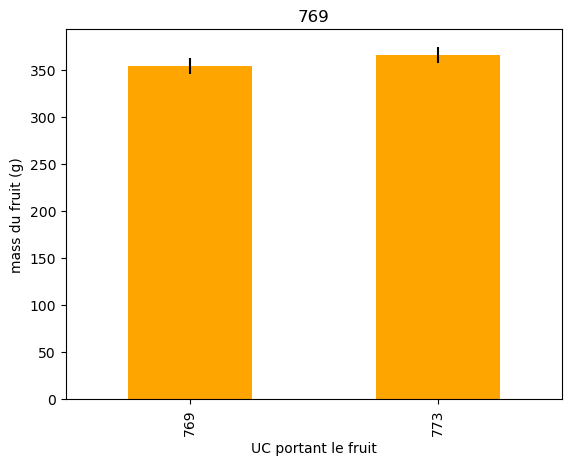

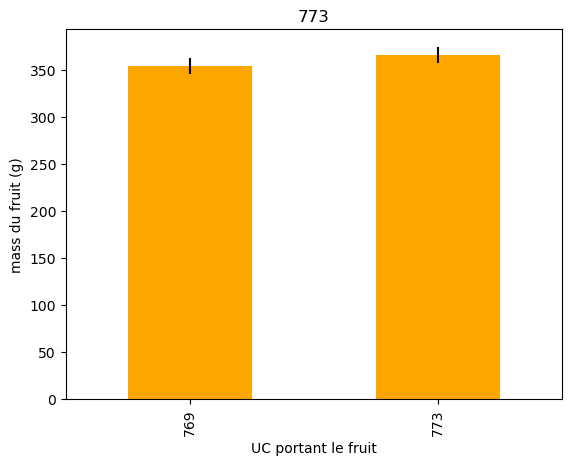

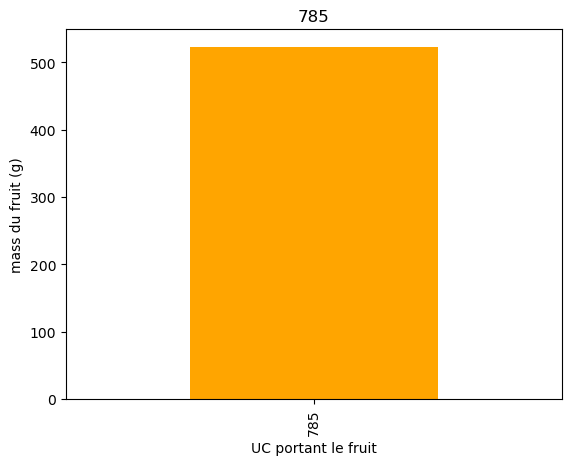

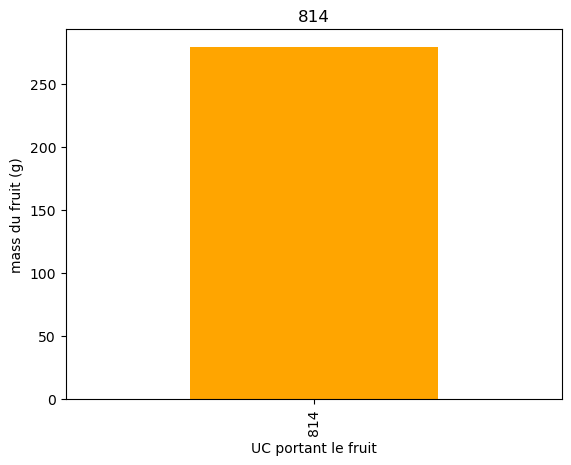

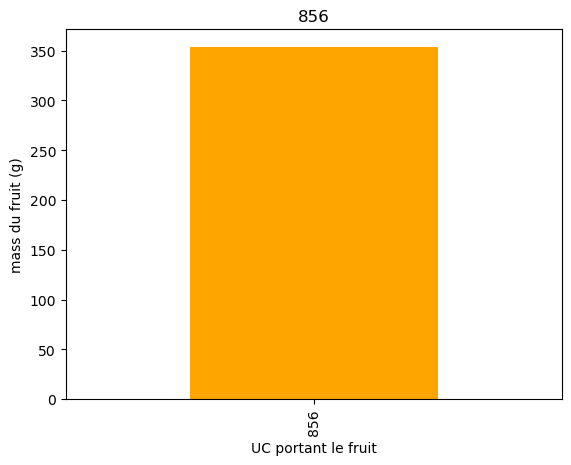

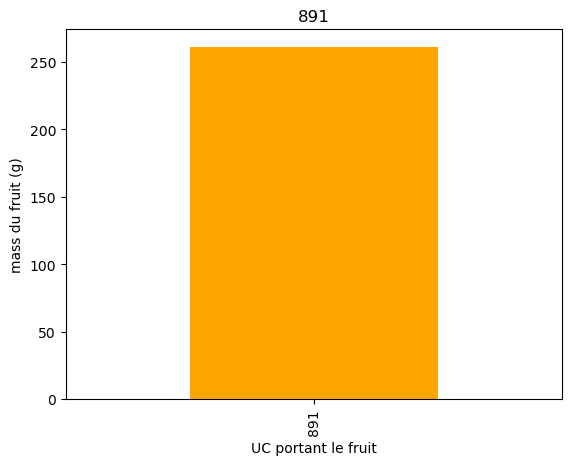

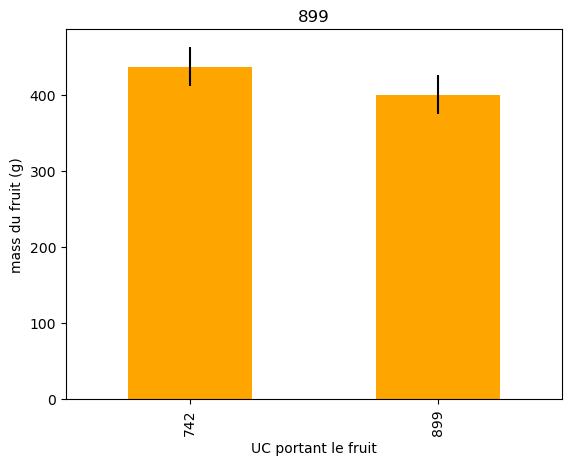

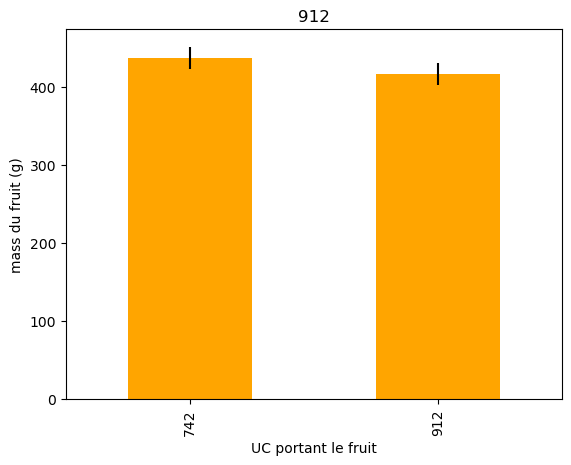

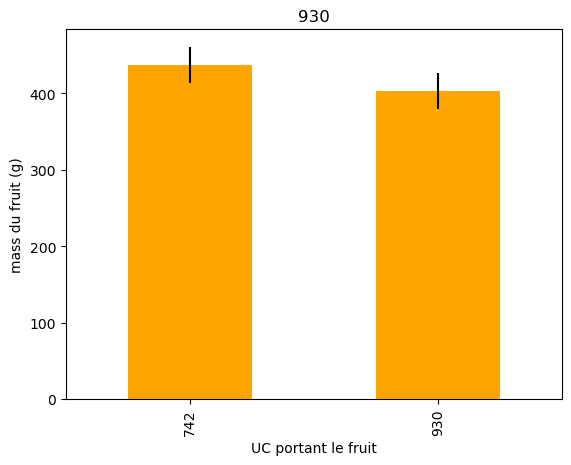

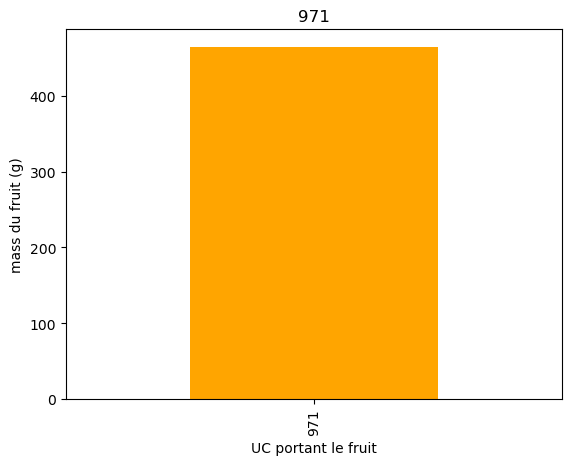

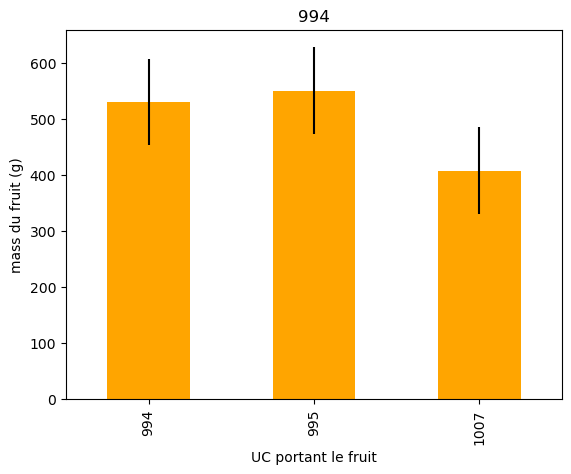

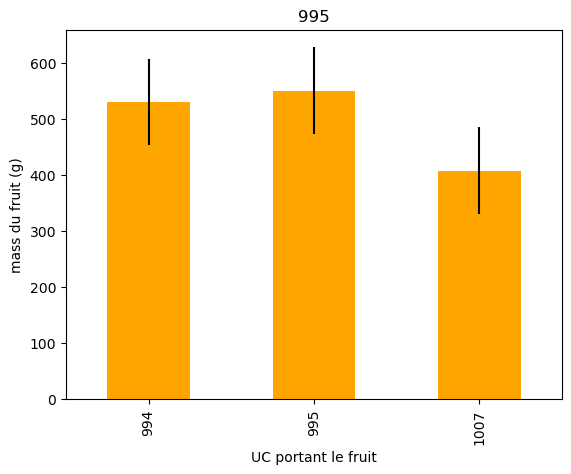

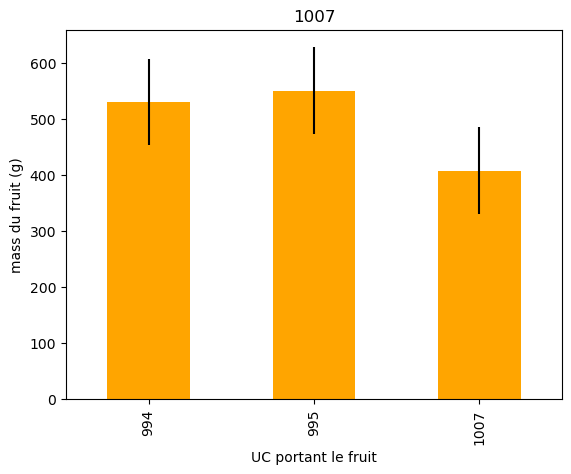

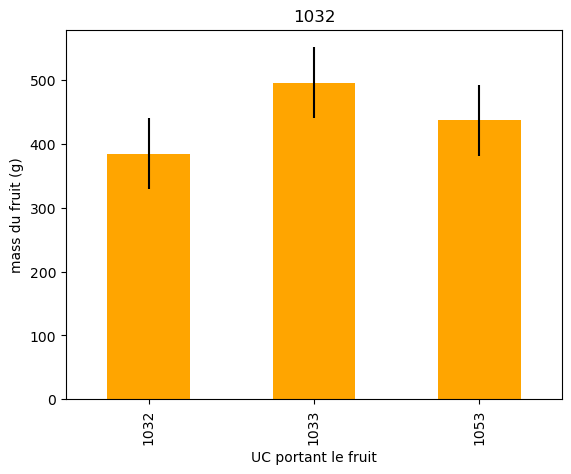

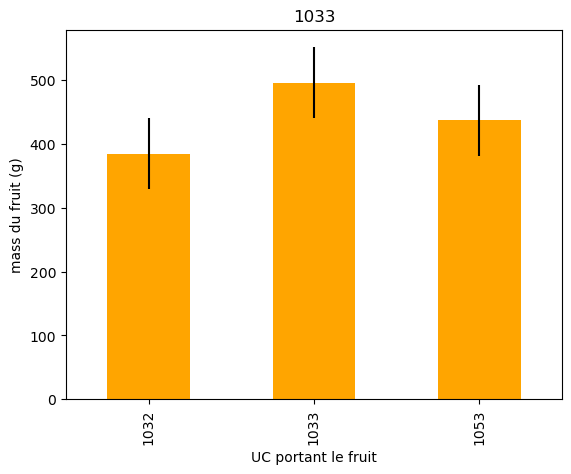

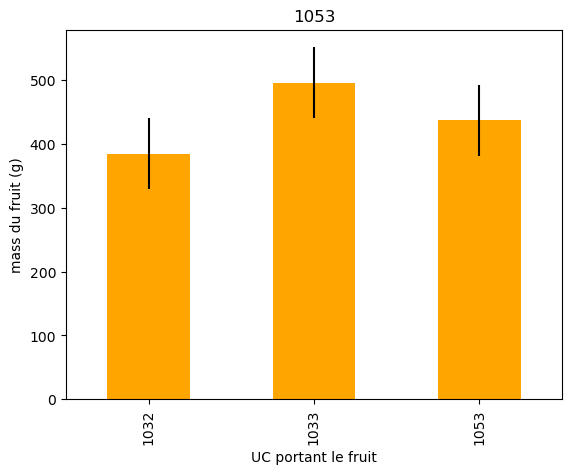

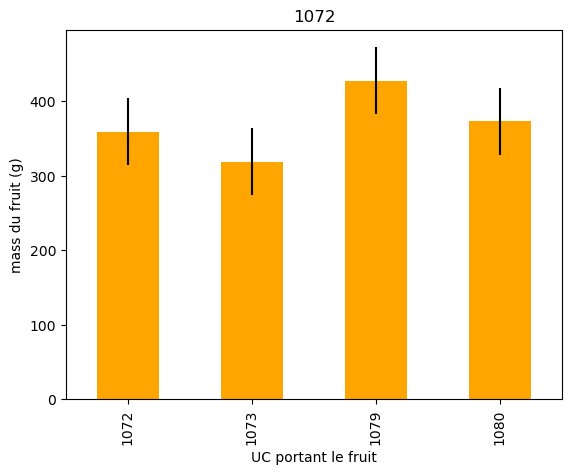

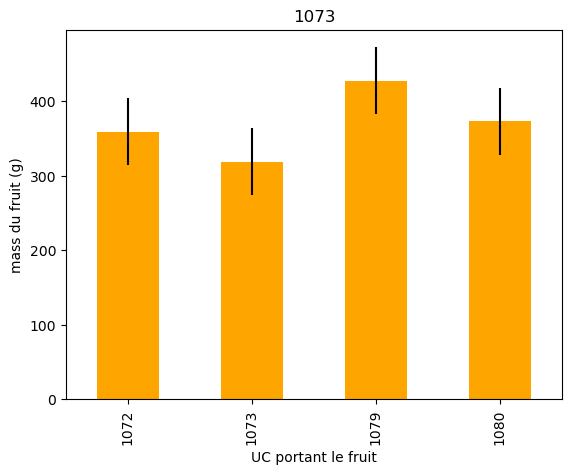

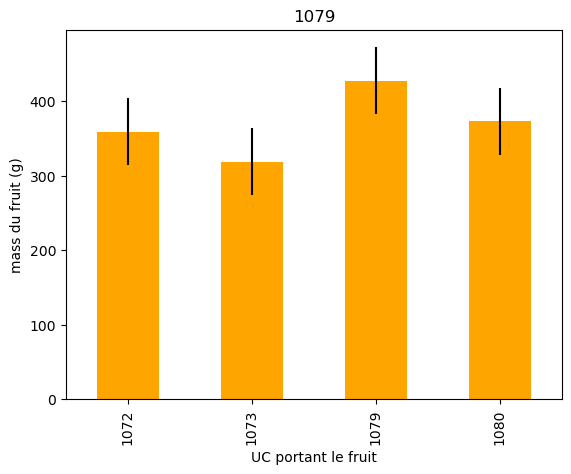

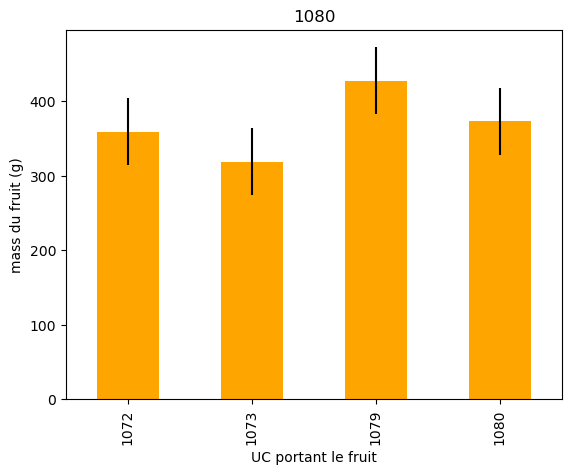

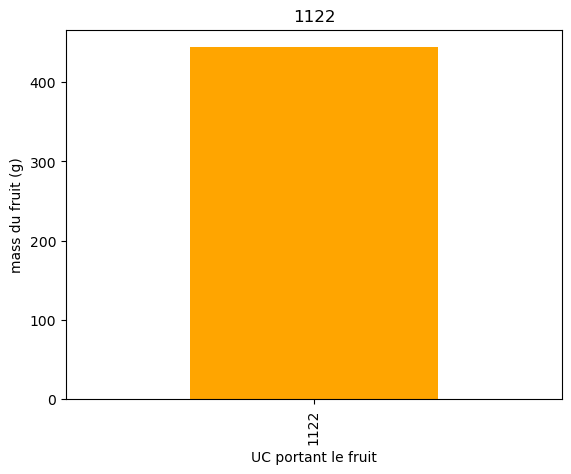

In [100]:
table = collect_branches(tree, 10)
for fruit in table.columns :
    selected_GU = table[fruit]
    selected_GU = pd.DataFrame(selected_GU[pd.notna(selected_GU)])
    selected_GU["standard deviation"] = np.full(fill_value=selected_GU.std(), shape = len(selected_GU))
    #print(selected_GU)
    plt.show(selected_GU[fruit].plot(kind="bar",title=fruit, xlabel="UC portant le fruit", ylabel="mass du fruit (g)", color="orange", yerr=selected_GU["standard deviation"]))

### Available carbon according to light environment

For each dmax between 0 and 10, the sum of available carbon for each fruit is plotted :

In [101]:
table_carbon = final_table.loc["shared light carbon"]
table_carbon["sum_carbon"] = table_carbon.sum(axis=1)
table_carbon

58         69         71        165        205        241  \
distance                                                                     
0          0.440719   0.749802   2.142292   0.867708   0.515375   2.078156   
1          0.440719   0.950802   2.343292   0.991667   0.957125   4.040859   
2          0.440719   4.985451   4.985451    2.23125   0.957125   5.426297   
3          1.004792   5.169556   5.169556    2.23125    1.03075   5.888109   
4          5.766438   7.211806   7.211806   2.355208   1.067563   5.950641   
5          8.393896   7.238875   7.238875   2.616766   1.509312   6.241253   
6          9.908719   7.708962   7.708962   2.841725   1.987875   6.292372   
7         10.443387  15.749016  15.749016   3.658266   2.171937      7.276   
8         15.007513  19.410714  19.410714   6.868506   2.981812   7.258752   
9         19.380231    16.9572    16.9572  10.185433   4.601562   7.245835   
10        18.197246  17.926413  17.926413    13.2086   5.362354   7.143249   
11        18.222246  18.034746  18.034746  13.353704   5.276458   6.627254   
12        18.109746  18.109746  18.109746  13.353704    5.44489   6.208287   
13        18.109746  18.109746  18.109746   13.63811  17.249826   6.615943   
14        18.109746  18.109746  18.109746  15.043287  12.697535  12.880618   
15        18.599309  18.109746  18.109746    15.6121   12.75574  13.657394   
16         18.57755  18.305571  18.305571  15.884079   12.93881  14.109358   
17        18.408923  18.408923  18.408923  15.911277  14.040307  13.950213   
18        18.632798  18.385611  18.385611  15.393589   15.74345   13.99526   
19        18.489777  18.489777  18.489777  15.250568  15.214879  14.858837   
20        18.431496  18.431496  18.431496  15.192287  15.220769  15.022428   
21        23.588766  18.341274  18.341274  14.912461  15.448721  13.807974   
22         22.82062  21.057992  21.057992  14.380025  12.511068  11.947332   

                246        254        261        289  ...        994  \
distance                                              ...              
0          5.506125    0.29375   0.586167   0.770938  ...     3.4755   
1         10.094563   0.979167   0.952521   1.593271  ...    6.70275   
2         10.706354   1.126042   0.952521   2.107229  ...   5.337375   
3         11.624042   1.370833   0.952521   2.621188  ...   7.819875   
4         11.686573   1.433365   0.952521   2.723979  ...   9.309375   
5          11.52131   1.940997   0.952521   2.826771  ...   9.309375   
6         11.422451   2.307055   0.952521   2.826771  ...  10.851307   
7          9.780344   4.567969   0.952521   2.826771  ...  17.239026   
8          7.258752   7.258752   1.591546   2.826771  ...  17.654914   
9          7.245835   7.245835   5.519161   2.826771  ...  12.753221   
10         7.143249   7.143249  57.701821   9.339031  ...  12.598882   
11         6.627254   6.627254  64.502344   9.575073  ...  11.449606   
12         6.208287   6.208287   68.71272  10.493271  ...  10.845908   
13         6.615943   6.615943  30.590501  28.527693  ...  10.333748   
14        12.880618  12.880618  21.094326  22.430126  ...  11.300122   
15        13.657394  13.657394  21.427254  19.354183  ...  11.292665   
16        14.109358  14.109358   20.38578  19.543037  ...  11.077587   
17        13.950213  13.950213  18.885703  19.957199  ...  11.359314   
18         13.99526   13.99526  20.638893   15.71841  ...  11.116696   
19        14.858837  14.858837  20.486218  14.431356  ...  10.813282   
20        15.022428  15.022428   21.25442  13.899731  ...  10.457829   
21        13.807974  13.807974  19.813803  11.260025  ...   9.765759   
22        11.947332  11.947332  16.162565   8.713131  ...   9.886942   

                995       1007       1032       1033       1053       1079  \
distance                                                                     
0           1.73775   0.847937   0.831396   0.237542   0.637828   0.658021   
1           2.23425   2.826458 

Distance dmax for which the available carbon is maximal :

In [102]:
table_carbon[table_carbon["sum_carbon"] == max(table_carbon["sum_carbon"])].index

Index([19], dtype='object', name='distance')

array([[<Axes: title={'center': '58'}, xlabel='distance to fruit', ylabel='availaible carbon'>,
        <Axes: title={'center': '69'}, xlabel='distance to fruit', ylabel='availaible carbon'>,
        <Axes: title={'center': '71'}, xlabel='distance to fruit', ylabel='availaible carbon'>,
        <Axes: title={'center': '165'}, xlabel='distance to fruit', ylabel='availaible carbon'>],
       [<Axes: title={'center': '205'}, xlabel='distance to fruit', ylabel='availaible carbon'>,
        <Axes: title={'center': '241'}, xlabel='distance to fruit', ylabel='availaible carbon'>,
        <Axes: title={'center': '246'}, xlabel='distance to fruit', ylabel='availaible carbon'>,
        <Axes: title={'center': '254'}, xlabel='distance to fruit', ylabel='availaible carbon'>],
       [<Axes: title={'center': '261'}, xlabel='distance to fruit', ylabel='availaible carbon'>,
        <Axes: title={'center': '289'}, xlabel='distance to fruit', ylabel='availaible carbon'>,
        <Axes: title={'center':

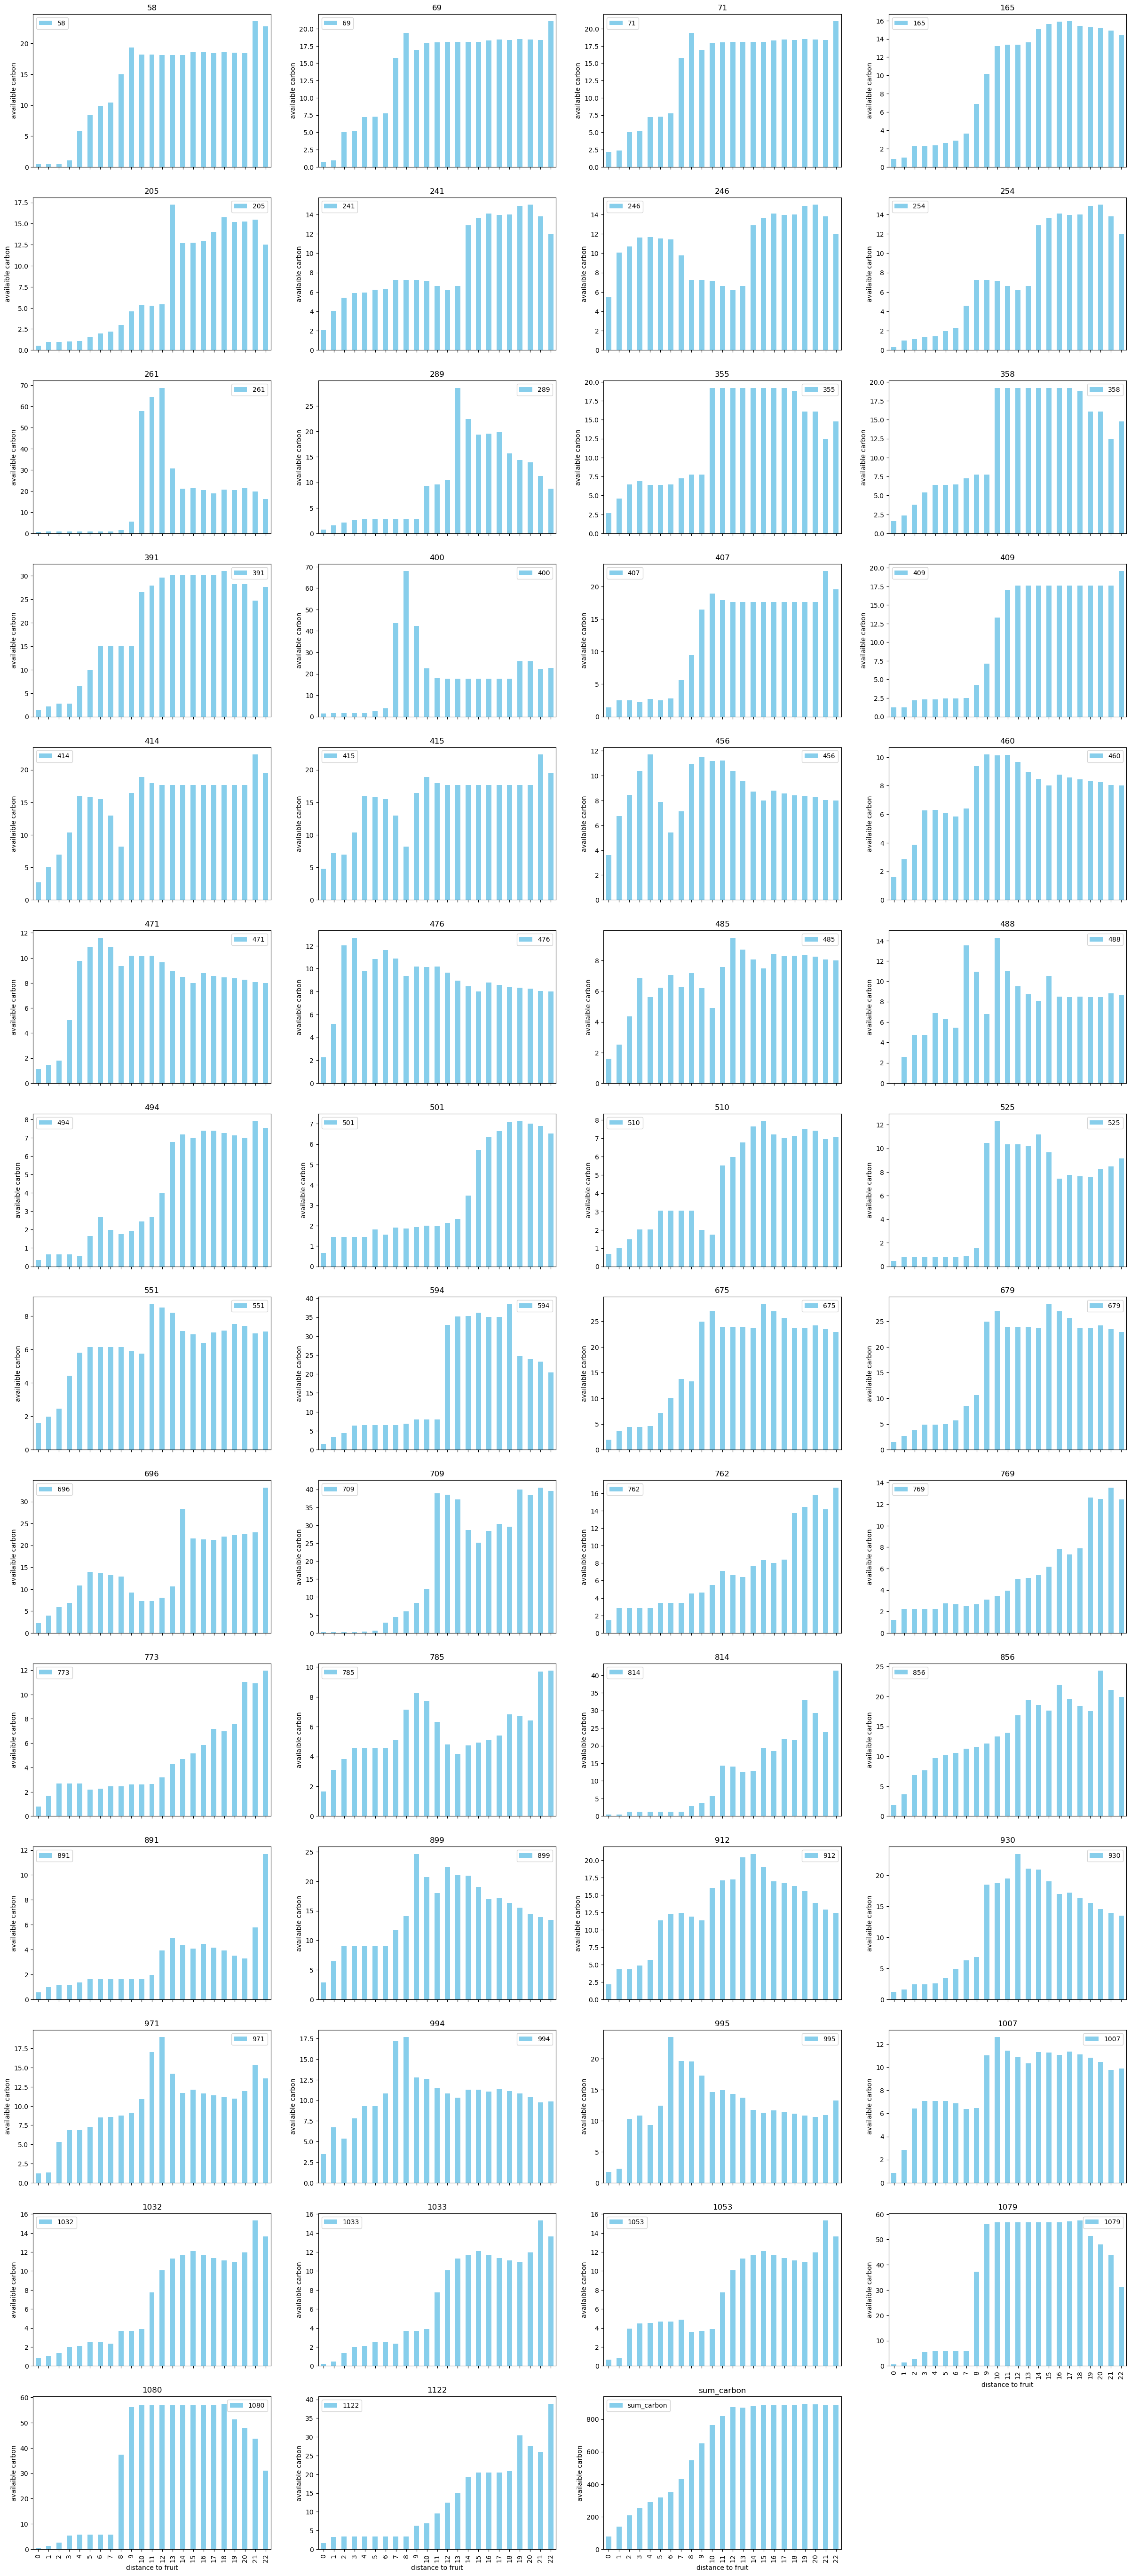

In [103]:
table_carbon.plot(kind='bar', subplots=True, figsize=(30,70), layout=(ceil(len(table_carbon.columns)/4), 4), xlabel="distance to fruit", ylabel="availaible carbon", color="skyblue")

### Number of GUs

Number of GUs in distance to fruit according to the distance from the fruit :

In [104]:
def get_number_of_GU_in_distance_to_fruit(tree, dmax, method = "exact"):
    graph = vmlab.to_graph(tree)
    adjacency = np.array(graph.get_adjacency())
    is_fruting = (tree['arch_dev__pot_nb_fruit'] > 0)

    # GU in distance
    if np.any(is_fruting) : 
        distance_to_fruit = csgraph.shortest_path( 
                                    adjacency,
                                    indices=np.flatnonzero(tree["arch_dev__pot_nb_fruit"]>0),
                                    directed=False
                                ).astype(np.float32)
        if method == "exact":
                    distance_to_fruit[distance_to_fruit != dmax] = np.inf #collecting GU at a dmax distance
        else :
                distance_to_fruit[distance_to_fruit > dmax] = np.inf #collecting GU under a dmax distance
        is_in_distance_to_fruit = np.isfinite(distance_to_fruit).astype(np.float32)

    number_of_GU_in_distance_to_fruit = np.nansum(is_in_distance_to_fruit, axis=1)
    return number_of_GU_in_distance_to_fruit

In [105]:
get_number_of_GU_in_distance_to_fruit(tree,10)

array([ 6.,  6.,  6.,  6., 29.,  8.,  4.,  4.,  4., 14.,  7.,  7., 12.,
        4.,  4.,  5.,  1.,  5.,  7.,  5.,  5.,  6.,  3.,  5.,  5.,  5.,
        5., 12.,  4.,  2.,  7.,  6.,  6.,  4., 12.,  7.,  7.,  7., 10.,
        9., 31., 10., 10., 10.,  6., 16.,  8.,  1., 15.,  9., 12., 18.,
       16., 12., 16., 17., 17., 17.,  3.,  3.,  2.,  2.,  7.],
      dtype=float32)

In [106]:
branches = [get_number_of_GU_in_distance_to_fruit(tree, i) for i in range (0,dmax+1)]

# table row names : id of the GU bearing the fruit 
branches = pd.DataFrame(branches, columns=np.flatnonzero(tree["arch_dev__pot_nb_fruit"]>0), index=[i for i in range (0, dmax+1)])
branches

58    69    71    165    173   205   241   246   254   261   ...  995   \
0    1.0   1.0   1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0  ...   1.0   
1    1.0   1.0   1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0  ...   1.0   
2    1.0   6.0   6.0   2.0    3.0   1.0   2.0   1.0   1.0   1.0  ...   5.0   
3    4.0   4.0   4.0   1.0    7.0   1.0   1.0   1.0   1.0   1.0  ...   3.0   
4    7.0   7.0   7.0   2.0    4.0   2.0   1.0   1.0   1.0   1.0  ...   3.0   
5    9.0   2.0   2.0   3.0    4.0   2.0   4.0   4.0   4.0   2.0  ...   5.0   
6   11.0   8.0   8.0   7.0   10.0   4.0   4.0   4.0   4.0   4.0  ...  11.0   
7    9.0  18.0  18.0   9.0   20.0   4.0   5.0   5.0   5.0   7.0  ...   9.0   
8   18.0  17.0  17.0  11.0   16.0   5.0   5.0   6.0   6.0   7.0  ...   9.0   
9   22.0  14.0  14.0   8.0   22.0   7.0   3.0   3.0   3.0  13.0  ...  16.0   
10   6.0   6.0   6.0   6.0   29.0   8.0   4.0   4.0   4.0  14.0  ...  12.0   
11   3.0   5.0   5.0   2.0   36.0   6.0   6.0   6.0   6.0  22.0  ...  19.0   
12   2.0   3.0   3.0   2.0   32.0   8.0   6.0   6.0   6.0  20.0  ...  13.0   
13   3.0   2.0   2.0   3.0   27.0   9.0   8.0   8.0   8.0   7.0  ...  15.0   
14   2.0   3.0   3.0   4.0   21.0  17.0  10.0  10.0  10.0   7.0  ...   5.0   
15   4.0   2.0   2.0   2.0   21.0  13.0  18.0  18.0  18.0  14.0  ...   3.0   
16   4.0   4.0   4.0   2.0   29.0   7.0  15.0  15.0  15.0  10.0  ...   6.0   
17   6.0   4.0   4.0   3.0   46.0  12.0   7.0   7.0   7.0  14.0  ...   4.0   
18  10.0   6.0   6.0   2.0   48.0  14.0   7.0   7.0   7.0  19.0  ...   8.0   
19   8.0  10.0  10.0   4.0   64.0  10.0  14.0  14.0  14.0  17.0  ...  14.0   
20  13.0   8.0   8.0   4.0   76.0  14.0  10.0  10.0  10.0  16.0  ...  20.0   
21  15.0  13.0  13.0   7.0  107.0  19.0  14.0  14.0  14.0  19.0  ...  20.0   
22  21.0  15.0  15.0  10.0  129.0  17.0  19.0  19.0  19.0  16.0  ...  24.0   

    1007  1032  1033  1053  1072  1073  1079  1080  1122  
0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  
1    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  
2    3.0   3.0   3.0   7.0   3.0   3.0   4.0   4.0   1.0  
3    1.0   2.0   2.0   2.0   2.0   2.0   4.0   4.0   1.0  
4    1.0   3.0   3.0   2.0   2.0   2.0   2.0   2.0   1.0  
5    1.0   6.0   6.0   4.0   3.0   3.0   1.0   1.0   1.0  
6    3.0   4.0   4.0   5.0   3.0   3.0   1.0   1.0   1.0  
7    6.0   6.0   6.0   8.0   6.0   6.0   2.0   2.0   3.0  
8   10.0  14.0  14.0  10.0   6.0   6.0   4.0   4.0   4.0  
9   20.0   9.0   9.0   9.0   3.0   3.0   2.0   2.0   9.0  
10  16.0  17.0  17.0  17.0   3.0   3.0   2.0   2.0   7.0  
11  12.0  17.0  17.0  17.0   6.0   6.0   3.0   3.0   7.0  
12  19.0  20.0  20.0  20.0   9.0   9.0   1.0   1.0   7.0  
13  13.0  18.0  18.0  18.0  11.0  11.0   2.0   2.0   4.0  
14  15.0   9.0   9.0   9.0   9.0   9.0   3.0   3.0   5.0  
15   5.0   6.0   6.0   6.0  18.0  18.0   6.0   6.0   3.0  
16   3.0   4.0   4.0   4.0  24.0  24.0   9.0   9.0   3.0  
17   6.0   8.0   8.0   8.0  25.0  25.0  11.0  11.0   8.0  
18   4.0  14.0  14.0  14.0  36.0  36.0   9.0   9.0  10.0  
19   8.0  20.0  20.0  20.0  44.0  44.0  18.0  18.0  12.0  
20  14.0  20.0  20.0  20.0  45.0  45.0  24.0  24.0   9.0  
21  20.0  24.0  24.0  24.0  60.0  60.0  25.0  25.0  16.0  
22  20.0  26.0  26.0  26.0  76.0  76.0  36.0  36.0  23.0  

[23 rows x 63 columns]

array([[<Axes: title={'center': '58'}, xlabel='distance to fruit', ylabel='number of GU in distance'>,
        <Axes: title={'center': '69'}, xlabel='distance to fruit', ylabel='number of GU in distance'>,
        <Axes: title={'center': '71'}, xlabel='distance to fruit', ylabel='number of GU in distance'>,
        <Axes: title={'center': '165'}, xlabel='distance to fruit', ylabel='number of GU in distance'>],
       [<Axes: title={'center': '173'}, xlabel='distance to fruit', ylabel='number of GU in distance'>,
        <Axes: title={'center': '205'}, xlabel='distance to fruit', ylabel='number of GU in distance'>,
        <Axes: title={'center': '241'}, xlabel='distance to fruit', ylabel='number of GU in distance'>,
        <Axes: title={'center': '246'}, xlabel='distance to fruit', ylabel='number of GU in distance'>],
       [<Axes: title={'center': '254'}, xlabel='distance to fruit', ylabel='number of GU in distance'>,
        <Axes: title={'center': '261'}, xlabel='distance to fruit

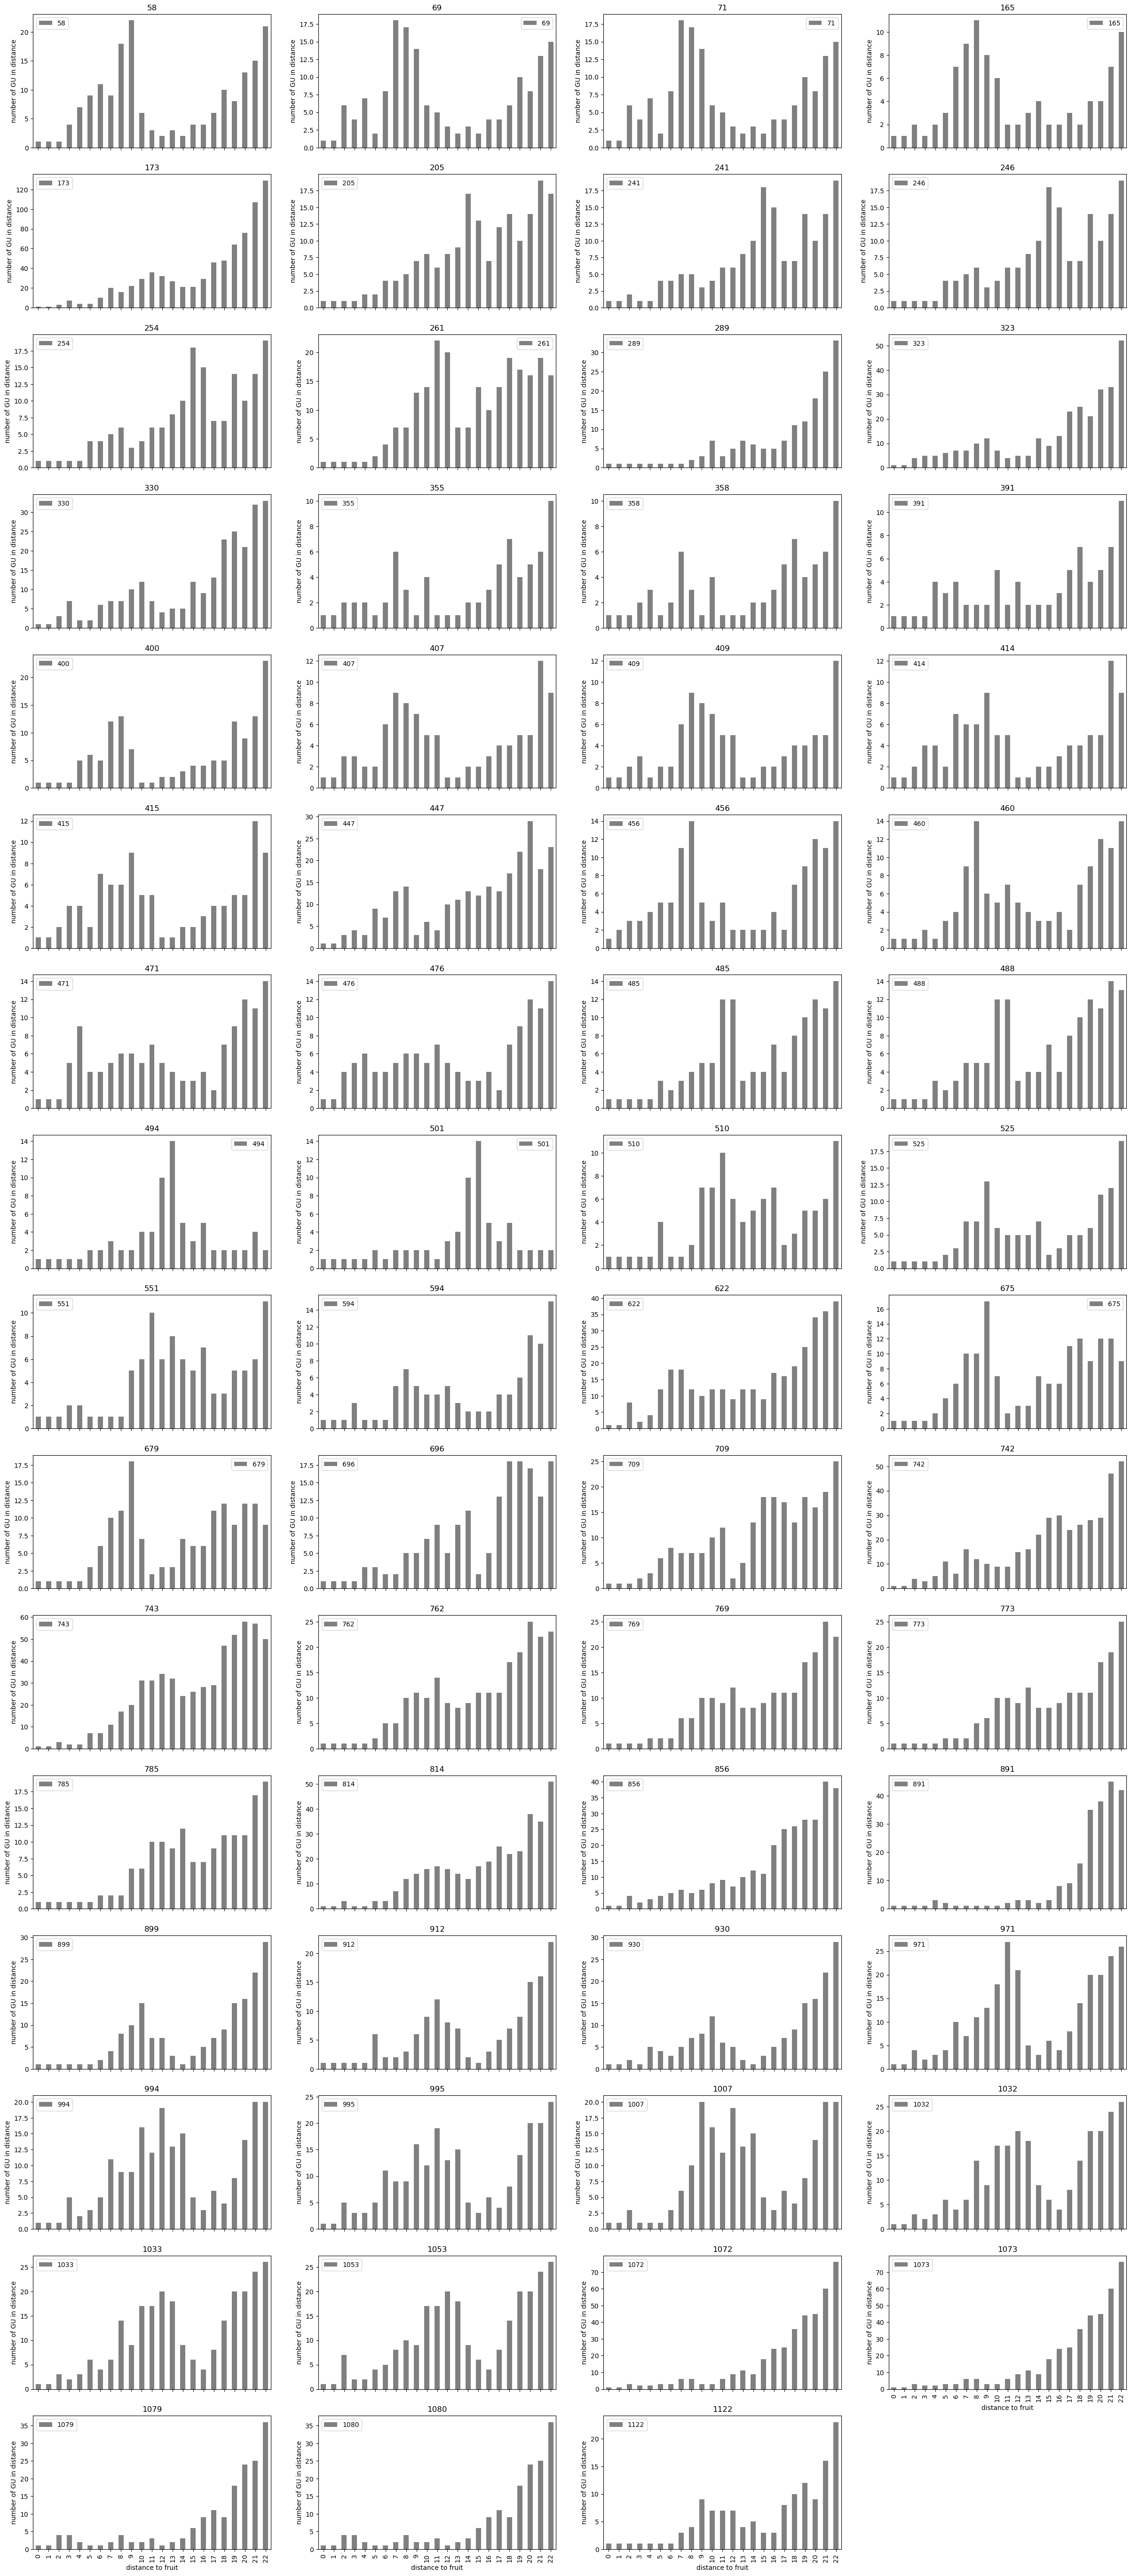

In [107]:
branches.plot(kind='bar',subplots=True, figsize=(30,70), layout=(ceil(len(branches.columns)/4), 4), xlabel="distance to fruit", ylabel="number of GU in distance", color="grey")